<a href="https://colab.research.google.com/github/anasnafis77/Deteksi-Glaukoma/blob/main/Notebooks/Inferencing_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
path = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/'

In [3]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import random
import tensorflow as tf
from ipywidgets import interact
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

#  Fungsi

In [4]:
def plot_metrik_threshold(thresholds, acc, sen, spe, youd, ax, i, fitur, dataset, n):
  X = thresholds
  y1 = acc
  y2 = sen
  y3 = spe
  y4 = youd

  max_youd = np.max(y4)
  t_youd = X[y4.index(max_youd)]
  idx = X.index(t_youd)
  max_acc = y1[idx]
  max_sen = y2[idx]
  max_spe = y3[idx]

  ax[i].plot(X, y1, color='royalblue', label='Accuracy')
  ax[i].plot(X, y2, color='orange', label='Sensitivity')
  ax[i].plot(X, y3, color='mediumseagreen', label='Specificity')
  ax[i].plot(X, y4, color='salmon', label='Youden index')
  ax[i].scatter(t_youd, max_acc, marker='o', color='royalblue', lw=0.25)
  ax[i].scatter(t_youd, max_sen, marker='o', color='orange', lw=0.25)
  ax[i].scatter(t_youd, max_spe, marker='o', color='mediumseagreen', lw=0.25)
  ax[i].scatter(t_youd, max_youd, marker='o', color='salmon', lw=0.25)

  ax[i].axvline(x=t_youd, linestyle='--', color='salmon', lw=1)

  ax[i].text(t_youd, 0.4, '{:.3f}'.format(t_youd), size='medium')
  ax[i].set_xlabel('Threshold')
  ax[i].set_ylabel('Metrik')
  ax[i].text(t_youd, max_acc, '{:.3f}'.format(max_acc), size='medium', color='darkblue')
  ax[i].text(t_youd, max_sen-0.01, '{:.3f}'.format(max_sen), size='medium', color='darkorange')
  ax[i].text(t_youd, max_spe+0.04, '{:.3f}'.format(max_spe), size='medium', color='darkgreen')
  ax[i].text(t_youd, max_youd, '{:.3f}'.format(max_youd), size='medium', color='red')
  ax[i].grid()
  ax[i].set_title('Nilai metrik {} {} (n={})'.format(fitur, dataset, n))
  ax[i].legend()

def all_threshold_metric(x_GT, y):
  X = x_GT
  y_true = y
  thresholds = []
  acc = []
  sen = []
  spe = []
  youd = []
  for i in range(100):
    thd = i*0.01
    y_pred = threshold_pred(X, threshold=thd)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc1, sen1, spe1, f1, youden = metrik(tn, fp, fn, tp)
    thresholds.append(thd)
    sen.append(sen1)
    spe.append(spe1)
    acc.append(acc1)
    youd.append(youden)
  return thresholds, acc, sen, spe, youd

In [5]:
def metrik(tn, fp, fn, tp):
  acc = (tp + tn) / (tp + tn + fp + fn)
  sen = tp / (tp + fn)
  spe = tn / (tn + fp)
  f = 2*tp / (2*tp + fp + fn)
  youden = sen + spe - 1
  return acc, sen, spe, f, youden

def threshold_pred(CDRS, threshold=0.56):
  pred = []
  for CDR in CDRS:
    if CDR < threshold:
      pred.append(0)
    elif CDR >= threshold:
      pred.append(1)
  pred = np.array(pred)
  return pred

In [6]:
def encoder(y):
  encoded = []
  for label in y:
    if label == 'Glaucoma':
      encoded.append(1)
    elif label == 'Normal':
      encoded.append(0)
  
  encoded = np.array(encoded)
  return encoded

In [7]:
def index_shuffle(f, random_state=4):
  ix_dr_gl = np.array(list(range(0, 32)))
  ix_dr_n = np.array(list(range(32, 50)))
  ix_re_gl = np.array(list(range(50, 90)))
  ix_re_n = np.array(list(range(90, 450)))
  
  random.Random(random_state).shuffle(ix_dr_gl)
  random.Random(random_state).shuffle(ix_dr_n)
  random.Random(random_state).shuffle(ix_re_gl)
  random.Random(random_state).shuffle(ix_re_n)
  # test_size = 1/k
  # [x*test_size for x in list(range(0, 33, test_size*32))]
  dr_gl = np.array([0, 6, 12, 18, 25, 32]) # portion of each fold for drishti-glaucoma data
  dr_n = np.array([0, 3, 6, 10, 14, 18]) # portion of each fold for drishti-normal data
  re_gl = np.array([0, 8, 16, 24, 32, 40]) # portion of each fold for refuge-glaucoma data
  re_n = np.array([0, 72, 144, 216, 288, 360]) # portion of each fold for refuge-normal data
  
  i = f - 1
  # meta-index for train data
  tr_dr_gl = list(range(dr_gl[i])) + list(range(dr_gl[i+1], 32))
  tr_dr_n = list(range(dr_n[i])) + list(range(dr_n[i+1], 18))
  tr_re_gl = list(range(re_gl[i])) + list(range(re_gl[i+1], 40))
  tr_re_n = list(range(re_n[i])) + list(range(re_n[i+1], 360))

  # meta-index for test data
  te_dr_gl = list(range(dr_gl[i], dr_gl[i+1])) 
  te_dr_n = list(range(dr_n[i], dr_n[i+1]))
  te_re_gl = list(range(re_gl[i], re_gl[i+1]))
  te_re_n = list(range(re_n[i], re_n[i+1]))

  ix_train = np.concatenate((ix_dr_gl[tr_dr_gl], ix_dr_n[tr_dr_n],
                               ix_re_gl[tr_re_gl], ix_re_n[tr_re_n]))
  ix_test = np.concatenate((ix_dr_gl[te_dr_gl], ix_dr_n[te_dr_n],
                              ix_re_gl[te_re_gl],  ix_re_n[te_re_n]))
  
  random.Random(random_state).shuffle(ix_train)
  random.Random(random_state).shuffle(ix_test)


  return ix_train, ix_test

In [9]:
df = pd.read_json(path+'dataframe.json')
result = pd.read_json(path+'result.json')
inf_df = pd.read_json(path+'inference_data.json')
train_ix, test_ix = index_shuffle(f=2)

In [10]:
gl_ix = df.index[df['tag']=='Glaucoma'].tolist()
n_ix = df.index[df['tag']=='Normal'].tolist()
dr_gl_ix = [x for x in gl_ix if x < 50]
re_gl_ix = [x for x in gl_ix if x >= 50]
dr_n_ix = [x for x in n_ix if x < 50]
re_n_ix = [x for x in n_ix if x >= 50]
dr_tr = [x for x in train_ix if x < 50]
dr_ts = [x for x in test_ix if x < 50]
re_tr = [x for x in train_ix if x >= 50]
re_ts = [x for x in test_ix if x >= 50]
dr_gl_tr = [x for x in dr_tr if x <= 32]
dr_n_tr = [x for x in dr_tr if x > 32]
re_gl_tr = [x for x in re_tr if x <= 90]
re_n_tr = [x for x in re_tr if x > 90]
dr_gl_ts = [x for x in dr_ts if x <= 32]
dr_n_ts = [x for x in dr_ts if x > 32]
re_gl_ts = [x for x in re_ts if x <= 90]
re_n_ts = [x for x in re_ts if x > 90]
print(len(dr_gl_ix)+len(dr_n_ix))
print(len(re_gl_ix)+len(re_n_ix))

50
400


In [11]:
def CDR_calc(OD_mask, OC_mask):
  try:
    c_OD,_ = cv2.findContours(OD_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    p_OD = cv2.approxPolyDP(c_OD[0], 3, True)
    c_OC,_ = cv2.findContours(OC_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    p_OC = cv2.approxPolyDP(c_OC[0], 3, True)
    x_OD, y_OD, hor_OD, ver_OD = cv2.boundingRect(p_OD)
    x_OC, y_OC, hor_OC, ver_OC = cv2.boundingRect(p_OC)
    area_OD = np.sum(OD_mask == 255)/255
    area_OC = np.sum(OC_mask == 255)/255

    VCDR = ver_OC/ver_OD # vertical CDR
    HCDR = hor_OC/ hor_OD # Horizontal CDR
    ACDR = area_OC/ area_OD # Area CDR
    turunan_OD={'ver': ver_OD, 'hor':hor_OD, 'area':area_OD}
    turunan_OC={'ver': ver_OC, 'hor':hor_OC, 'area':area_OC}

  except:
    VCDR = float("nan")
    HCDR = float("nan")
    ACDR = float("nan")
    
  return VCDR, HCDR, ACDR, turunan_OD, turunan_OC

In [12]:
def make_linear(X, Y):
  linear_regressor = LinearRegression()  # create object for the class
  linear_regressor.fit(X, Y)  # perform linear regression
  Y_pred = linear_regressor.predict(X)  # make predictions
  return Y_pred

def r_squared(X, Y):
  X = X.squeeze()
  Y = Y.squeeze()
  correlation_matrix = np.corrcoef(X, Y)
  correlation_xy = correlation_matrix[0,1]
  r_square = correlation_xy**2
  return r_square

# Data Acquisition

In [ ]:
df.groupby(['dataset', 'tag']).size()

dataset  tag     
drishti  Glaucoma     32
         Normal       18
refuge   Glaucoma     40
         Normal      360
dtype: int64

In [ ]:
# vertical CDR perhitungan mandiri pada mask gt
VCDR_gtm = []
VCDR_seg = []
VCDR_gtm = []
VCDR_seg = []
HCDR_gtm = []
HCDR_seg = []
ACDR_gtm = []
ACDR_seg = []
ver_OD_gtm = []
ver_OC_gtm = []
ver_OD_seg = []
ver_OC_seg = []
hor_OD_gtm = []
hor_OC_gtm = []
hor_OD_seg = []
hor_OC_seg = []
area_OD_gtm = []
area_OC_gtm = []
area_OD_seg = []
area_OC_seg = []
nan_ix = []
for i in tqdm(range(len(df))):
  OD_gt = cv2.imread(df['path_OD_png'][i], 0)
  OC_gt = cv2.imread(df['path_OC_png'][i], 0)
  OD_seg = cv2.imread('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Hasil segmentasi/semantic fixed/OD_{}.png'.format(i+1), 0)
  OC_seg = cv2.imread('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Hasil segmentasi/semantic fixed/OC_{}.png'.format(i+1), 0)
  VCDR_gt, HCDR_gt, ACDR_gt, turunan_OD_gt, turunan_OC_gt = CDR_calc(OD_gt, OC_gt)
  VCDR_sg, HCDR_sg, ACDR_sg, turunan_OD_sg, turunan_OC_sg= CDR_calc(OD_seg, OC_seg)

  VCDR_gtm.append(VCDR_gt)
  VCDR_seg.append(VCDR_sg)
  HCDR_gtm.append(HCDR_gt)
  HCDR_seg.append(HCDR_sg)
  ACDR_gtm.append(ACDR_gt)
  ACDR_seg.append(ACDR_sg)
  ver_OD_gtm.append(turunan_OD_gt['ver'])
  ver_OC_gtm.append(turunan_OC_gt['ver'])
  ver_OD_seg.append(turunan_OD_sg['ver'])
  ver_OC_seg.append(turunan_OC_sg['ver'])
  hor_OD_gtm.append(turunan_OD_gt['hor'])
  hor_OC_gtm.append(turunan_OC_gt['hor'])
  hor_OD_seg.append(turunan_OD_sg['hor'])
  hor_OC_seg.append(turunan_OC_sg['hor'])
  area_OD_gtm.append(turunan_OD_gt['area'])
  area_OC_gtm.append(turunan_OC_gt['area'])
  area_OD_seg.append(turunan_OD_sg['area'])
  area_OC_seg.append(turunan_OC_sg['area'])

  if np.isnan(VCDR_sg):
    nan_ix.append(i)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
inf_df = pd.DataFrame({'VCDR Gold': df['mean VCDR'].tolist(), 'VCDR': VCDR_seg, 'HCDR': HCDR_seg, 
                       'ACDR': ACDR_seg, 'VCDR GT': VCDR_gtm, 'HCDR GT': HCDR_gtm,
                       'ACDR GT': ACDR_gtm, 
                       'ver OD GT': ver_OD_gtm, 'ver OC GT':ver_OC_gtm,
                       'ver OD seg': ver_OD_seg, 'ver OC seg': ver_OC_seg,
                       'hor OD GT': hor_OD_gtm, 'hor OC GT':hor_OC_gtm,
                       'hor OD seg': hor_OD_seg, 'hor OC seg': hor_OC_seg,
                       'area OD GT': area_OD_gtm, 'area OC GT':area_OC_gtm,
                       'area OD seg': area_OD_seg, 'area OC seg': area_OC_seg,
                       'tag': df['tag'].tolist()})
inf_df.to_csv('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/inference_data.csv')
inf_df.to_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/inference_data.json')

In [ ]:
inf_df = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/inference_data.json')

# Data Exploration

Hubungan antara vairabel

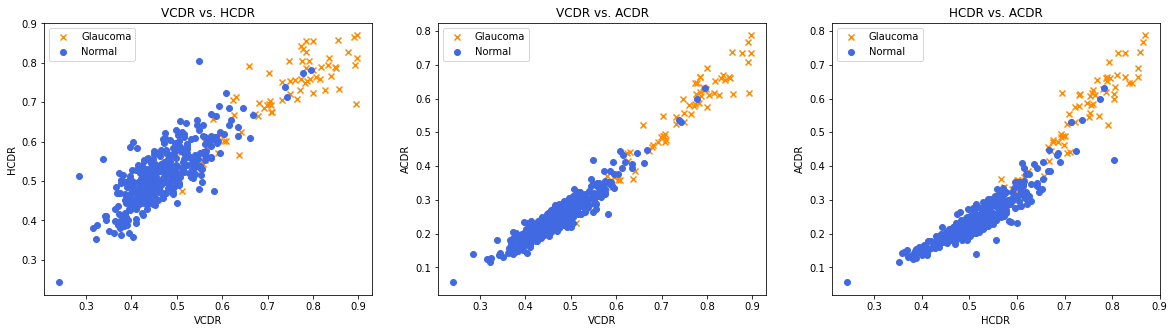

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].scatter(x=inf_df.loc[inf_df['tag']=='Glaucoma']['VCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Glaucoma']['HCDR GT'],
            marker='x', color ='darkorange', label='Glaucoma')
ax[0].scatter(x=inf_df.loc[inf_df['tag']=='Normal']['VCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Normal']['HCDR GT'],
            marker='o', color ='royalblue', label='Normal')
ax[0].set_title('VCDR vs. HCDR')
ax[0].set_xlabel('VCDR')
ax[0].set_ylabel('HCDR')
ax[0].legend()
ax[1].scatter(x=inf_df.loc[inf_df['tag']=='Glaucoma']['VCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Glaucoma']['ACDR GT'],
            marker='x', color ='darkorange', label='Glaucoma')
ax[1].scatter(x=inf_df.loc[inf_df['tag']=='Normal']['VCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Normal']['ACDR GT'],
            marker='o', color ='royalblue', label='Normal')
ax[1].set_title('VCDR vs. ACDR')
ax[1].set_xlabel('VCDR')
ax[1].set_ylabel('ACDR')
ax[1].legend()
ax[2].scatter(x=inf_df.loc[inf_df['tag']=='Glaucoma']['HCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Glaucoma']['ACDR GT'],
            marker='x', color ='darkorange', label='Glaucoma')
ax[2].scatter(x=inf_df.loc[inf_df['tag']=='Normal']['HCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Normal']['ACDR GT'],
            marker='o', color ='royalblue', label='Normal')
ax[2].set_title('HCDR vs. ACDR')
ax[2].set_xlabel('HCDR')
ax[2].set_ylabel('ACDR')
ax[2].legend()
plt.show()

Error analysis

In [ ]:
vcdr_error = inf_df['VCDR GT']-inf_df['VCDR']
hcdr_error = inf_df['HCDR GT']-inf_df['HCDR']
acdr_error = inf_df['ACDR GT']-inf_df['ACDR']
ix_error_vcdr = vcdr_error.index[(vcdr_error > (np.mean(vcdr_error) + np.std(vcdr_error)))|( vcdr_error < (np.mean(vcdr_error) - np.std(vcdr_error)))]
print(np.mean(vcdr_error) + np.std(vcdr_error))
print(np.mean(vcdr_error) - np.std(vcdr_error))

0.05093027829120141
-0.03985866151831253


In [ ]:
len(ix_error_vcdr)

113

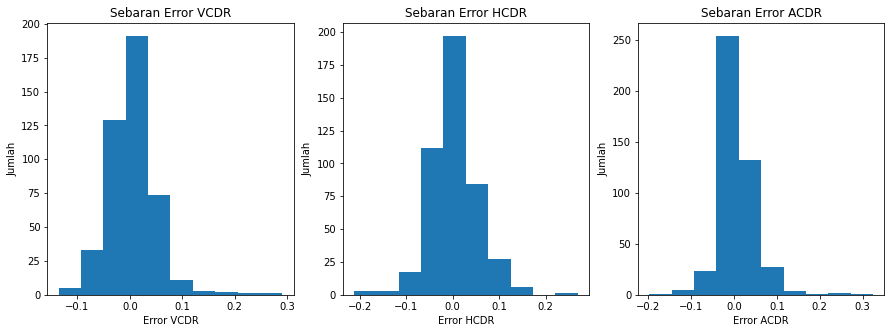

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.hist(vcdr_error)
plt.ylabel('Jumlah')
plt.xlabel('Error VCDR')
plt.title('Sebaran Error VCDR')
plt.subplot(1,3,2)
plt.hist(hcdr_error)
plt.ylabel('Jumlah')
plt.xlabel('Error HCDR')
plt.title('Sebaran Error HCDR')
plt.subplot(1,3,3)
plt.hist(acdr_error)
plt.ylabel('Jumlah')
plt.xlabel('Error ACDR')
plt.title('Sebaran Error ACDR')
plt.show()

In [ ]:
@interact(i=ix_error_vcdr)
def show_groundtruth(i=ix_error_vcdr[0]):
  
  img = cv2.imread(df['path_OD'][i], 0)
  ROI = 
  mask_OD_gt = cv2.imread(df['path_OD_png'][i], 0)
  mask_OC_gt = cv2.imread(df['path_OC_png'][i], 0)
  mask_OD = cv2.imread('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Hasil segmentasi/semantic fixed/OD_{}.png'.format(i+1), 0)
  mask_OC = cv2.imread('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Hasil segmentasi/semantic fixed/OC_{}.png'.format(i+1), 0)
  
  h, w = mask_OD_gt.shape[:2]
  mask_OD_gt_show = np.zeros((h, w, 3), np.uint8)
  mask_OD_show = np.zeros((h, w, 3), np.uint8)
  mask_OC_gt_show = np.zeros((h, w, 3), np.uint8)
  mask_OC_show = np.zeros((h, w, 3), np.uint8)

  mask_OD_gt_show[mask_OD_gt==255] = (255, 0, 0)
  mask_OD_show[mask_OD==255] = (0, 0, 255)

  mask_OC_gt_show[mask_OC_gt==255] = (255, 0, 0)
  mask_OC_show[mask_OC==255] = (0, 0, 255)

  DSC_OD = np.sum(mask_OD[mask_OD_gt==255])*2.0/(np.sum(mask_OD) + np.sum(mask_OD_gt))
  DSC_OC = np.sum(mask_OC[mask_OC_gt==255])*2.0/(np.sum(mask_OC) + np.sum(mask_OC_gt))

  plt.figure(figsize=(10, 10))
  plt.subplot(121),
  plt.imshow(mask_OD_gt_show, interpolation='none')
  plt.imshow(mask_OD_show, interpolation='none', alpha=0.35)
  plt.text(100, 100, 'DSC: {:.3f}'.format(DSC_OD), size='small', color='w')
  plt.subplot(122),
  plt.imshow(mask_OC_gt_show, interpolation='none')
  plt.imshow(mask_OC_show, interpolation='none', alpha=0.35)
  plt.text(100, 100, 'DSC: {:.3f}'.format(DSC_OC), size ='small', color='w')
  plt.show()

interactive(children=(Dropdown(description='i', options=(6, 7, 8, 22, 25, 26, 29, 33, 42, 43, 45, 48, 52, 53, …

In [ ]:
@interact(i=ix_error)
def show_groundtruth(i=ix_error[0]):
  
  mask_OD_gt = cv2.imread(df['path_OD_png'][i], 0)
  mask_OC_gt = cv2.imread(df['path_OC_png'][i], 0)
  mask_OD = cv2.imread('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Hasil segmentasi/semantic fixed/OD_{}.png'.format(i+1), 0)
  mask_OC = cv2.imread('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Hasil segmentasi/semantic fixed/OC_{}.png'.format(i+1), 0)
  h, w = mask_OD_gt.shape[:2]
  mask_OD_gt_show = np.zeros((h, w, 3), np.uint8)
  mask_OD_show = np.zeros((h, w, 3), np.uint8)
  mask_OC_gt_show = np.zeros((h, w, 3), np.uint8)
  mask_OC_show = np.zeros((h, w, 3), np.uint8)

  mask_OD_gt_show[mask_OD_gt==255] = (255, 0, 0)
  mask_OD_show[mask_OD==255] = (0, 0, 255)

  mask_OC_gt_show[mask_OC_gt==255] = (255, 0, 0)
  mask_OC_show[mask_OC==255] = (0, 0, 255)

  DSC_OD = np.sum(mask_OD[mask_OD_gt==255])*2.0/(np.sum(mask_OD) + np.sum(mask_OD_gt))
  DSC_OC = np.sum(mask_OC[mask_OC_gt==255])*2.0/(np.sum(mask_OC) + np.sum(mask_OC_gt))

  print('VCDR: ', inf_df['VCDR'][i])
  print('VCDR GT: ', inf_df['VCDR GT'][i])
  print(abs_error[i])
  plt.figure(figsize=(10, 10))
  plt.subplot(121),
  plt.imshow(mask_OD_gt_show, interpolation='none')
  plt.imshow(mask_OD_show, interpolation='none', alpha=0.35)
  plt.text(100, 100, 'DSC: {:.3f}'.format(DSC_OD), size='small', color='w')
  plt.subplot(122),
  plt.imshow(mask_OC_gt_show, interpolation='none')
  plt.imshow(mask_OC_show, interpolation='none', alpha=0.35)
  plt.text(100, 100, 'DSC: {:.3f}'.format(DSC_OC), size ='small', color='w')
  plt.show()

interactive(children=(Dropdown(description='i', options=(15, 17, 46), value=15), Output()), _dom_classes=('wid…

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

Text(0.5, 1.0, 'Boxplot ACDR GT')

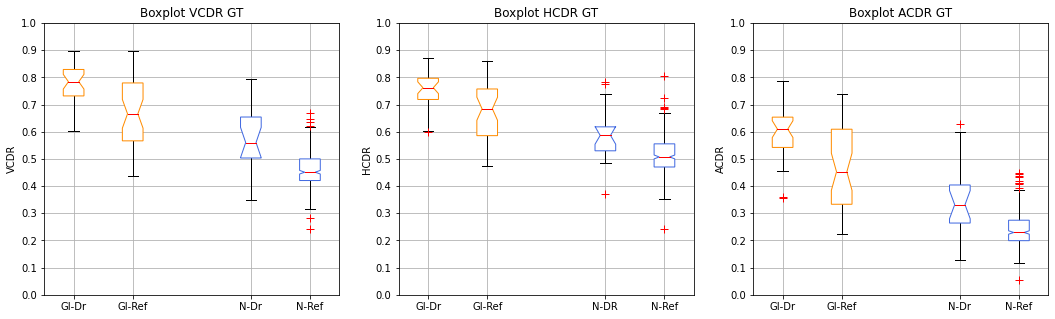

In [ ]:
plt.figure(figsize=(18, 5))
flierprops = dict(marker='+', markerfacecolor='g', markersize=8,
                  linestyle='none', markeredgecolor='r')
glprops = dict(color='darkorange', facecolor='w')
nprops = dict(color='royalblue',facecolor='w')
medianprops=dict(color='r')
data_VCDR_gl= [inf_df['VCDR GT'][dr_gl_ix], inf_df['VCDR GT'][re_gl_ix]]
data_VCDR_n = [inf_df['VCDR GT'][dr_n_ix], inf_df['VCDR GT'][re_n_ix]]

data_HCDR_gl= [inf_df['HCDR GT'][dr_gl_ix], inf_df['HCDR GT'][re_gl_ix]]
data_HCDR_n = [inf_df['HCDR GT'][dr_n_ix], inf_df['HCDR GT'][re_n_ix]]

data_ACDR_gl = [inf_df['ACDR GT'][dr_gl_ix], inf_df['ACDR GT'][re_gl_ix]]
data_ACDR_n  = [inf_df['ACDR GT'][dr_n_ix], inf_df['ACDR GT'][re_n_ix]]

plt.subplot(1,3,1), 
plt.boxplot(data_VCDR_gl, notch=True, positions=[1, 2], widths=0.35, flierprops=flierprops, boxprops=glprops, medianprops=medianprops, patch_artist=True)
plt.boxplot(data_VCDR_n, notch=True, positions=[4, 5], widths=0.35,flierprops=flierprops, boxprops=nprops, medianprops=medianprops, patch_artist=True)
plt.grid()
plt.yticks(ticks=[x*0.1 for x in range(0, 11)])
plt.ylabel('VCDR')
# plt.axhline(0.52, color = 'r', linestyle = '--', label = 'threshold')
plt.xticks([1, 2, 4, 5], labels=['Gl-Dr', 'Gl-Ref', 
                                 'N-Dr', 'N-Ref'])
plt.title('Boxplot VCDR GT')

plt.subplot(1,3,2)
plt.boxplot(data_HCDR_gl, notch=True, positions=[1, 2], widths=0.35,flierprops=flierprops, boxprops=glprops, medianprops=medianprops, patch_artist=True)
plt.boxplot(data_HCDR_n, notch=True, positions=[4, 5], widths=0.35,flierprops=flierprops, boxprops=nprops, medianprops=medianprops, patch_artist=True)
plt.grid()
plt.yticks(ticks=[x*0.1 for x in range(0, 11)])
plt.ylabel('HCDR')
# plt.axhline(0.52, color = 'r', linestyle = '--', label = 'threshold')
plt.xticks([1, 2, 4, 5], labels=['Gl-Dr', 'Gl-Ref', 
                                 'N-DR', 'N-Ref'])
plt.title('Boxplot HCDR GT')

plt.subplot(1,3,3), 
plt.boxplot(data_ACDR_gl, notch=True, positions=[1, 2], widths=0.35, flierprops=flierprops, boxprops=glprops, medianprops=medianprops, patch_artist=True)
plt.boxplot(data_ACDR_n, notch=True, positions=[4, 5], widths=0.35, flierprops=flierprops, boxprops=nprops, medianprops=medianprops, patch_artist=True)
plt.grid()
plt.yticks(ticks=[x*0.1 for x in range(0, 11)])
plt.ylabel('ACDR')
# plt.axhline(0.52, color = 'r', linestyle = '--', label = 'threshold')
plt.xticks([1, 2, 4, 5], labels=['Gl-Dr', 'Gl-Ref', 
                                 'N-Dr', 'N-Ref'])

plt.title('Boxplot ACDR GT')

# **VCDR Analysis**

Absolute error in all cases: 0.00744
Absolute error in glaucoma cases: 0.00541
Absolute error in normal cases: 0.00473


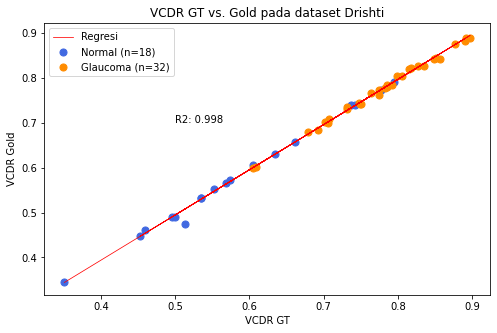

In [ ]:
abs_e = np.sum(abs(inf_df['VCDR Gold'][dr_ts]-inf_df['VCDR GT'][dr_ts]))/len(dr_ts)
xo = inf_df['VCDR GT'][dr_n_ix]
yo = inf_df['VCDR Gold'][dr_n_ix]
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df['VCDR GT'][dr_gl_ix]
yi = inf_df['VCDR Gold'][dr_gl_ix]
abs_e_re = np.sum(abs(xi-yi))/len(xi)

x = inf_df['VCDR GT'][:50].to_numpy().reshape(-1, 1)
y = inf_df['VCDR Gold'][:50].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))

plt.figure(figsize=(8, 5))
plt.scatter(xo, yo, s=50, marker='o', color='royalblue', label='Normal (n={})'.format(len(xo)))
plt.scatter(xi, yi, s=50, marker='o', color='darkorange', label='Glaucoma (n={})'.format(len(xi)))
plt.plot(x, y_lin, color='r', label='Regresi', lw=0.75)
plt.ylabel('VCDR Gold')
plt.xlabel('VCDR GT')
plt.title('VCDR GT vs. Gold pada dataset Drishti')
plt.text(0.5, 0.7, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Absolute error in all cases: 0.04153
Absolute error in glaucoma cases: 0.03707
Absolute error in normal cases: 0.04404


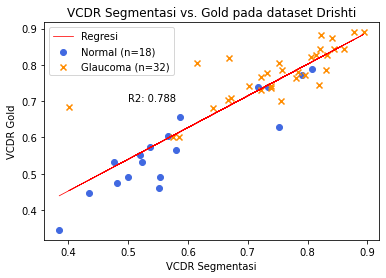

In [ ]:
abs_e = np.sum(abs(inf_df['VCDR Gold'][:50]-inf_df['VCDR'][:50]))/ 50
xo = inf_df['VCDR'][dr_n_ix]
yo = inf_df['VCDR Gold'][dr_n_ix]
xi = inf_df['VCDR'][dr_gl_ix]
yi = inf_df['VCDR Gold'][dr_gl_ix]
abs_e_dr = np.sum(abs(xo-yo))/len(xo)

abs_e_re = np.sum(abs(xi-yi))/len(xi)

x = inf_df['VCDR'][:50].to_numpy().reshape(-1, 1)
y = inf_df['VCDR Gold'][:50].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))

plt.figure(figsize=(8, 5))
plt.scatter(xo, yo, s=60, marker='o', color='royalblue', label='Normal (n={})'.format(len(xo)))
plt.scatter(xi, yi, s=60, marker='x', color='darkorange', label='Glaucoma (n={})'.format(len(xi)))
plt.plot(x, y_lin, color='r', label='Regresi', lw=0.75)
plt.ylabel('VCDR Gold')
plt.xlabel('VCDR Segmentasi')
plt.title('VCDR Segmentasi vs. Gold pada dataset Drishti')
plt.text(0.5, 0.7, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Absolute error in all cases: 0.09609
Absolute error in glaucoma cases: 0.03342
Absolute error in normal cases: 0.02890


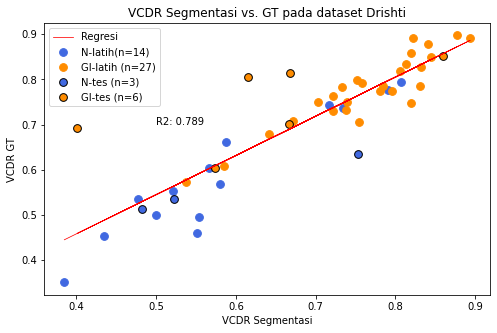

In [ ]:
abs_e = np.sum(abs(inf_df['VCDR GT'][dr_ts]-inf_df['VCDR'][dr_ts]))/len(dr_ts)
xo = inf_df['VCDR'][dr_n_tr]
yo = inf_df['VCDR GT'][dr_n_tr]
xi = inf_df['VCDR'][dr_gl_tr]
yi = inf_df['VCDR GT'][dr_gl_tr]
XO = inf_df['VCDR'][dr_n_ts]
YO = inf_df['VCDR GT'][dr_n_ts]
XI = inf_df['VCDR'][dr_gl_ts]
YI = inf_df['VCDR GT'][dr_gl_ts]

abs_e_dr = np.sum(abs(xo-yo))/len(xo)
abs_e_re = np.sum(abs(xi-yi))/len(xi)

x = inf_df['VCDR'][:50].to_numpy().reshape(-1, 1)
y = inf_df['VCDR GT'][:50].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))
plt.figure(figsize=(8, 5))
plt.scatter(xo, yo, s=60, marker='o', color='royalblue', label='N-latih(n={})'.format(len(xo)))
plt.scatter(xi, yi, s=60,marker='o', color='darkorange', label='Gl-latih (n={})'.format(len(xi)))
plt.scatter(XO, YO, s=60,marker='o', color='royalblue', edgecolors='k', label='N-tes (n={})'.format(len(XO)))
plt.scatter(XI, YI, s=60,marker='o', color='darkorange', edgecolors='k', label='Gl-tes (n={})'.format(len(XI)))
plt.plot(x, y_lin, color='r', label='Regresi', lw=0.75)
plt.ylabel('VCDR GT')
plt.xlabel('VCDR Segmentasi')
plt.title('VCDR Segmentasi vs. GT pada dataset Drishti')
plt.text(0.5, 0.7, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Absolute error in all cases: 0.09457
Absolute error in glaucoma cases: 0.04359
Absolute error in normal cases: 0.03755


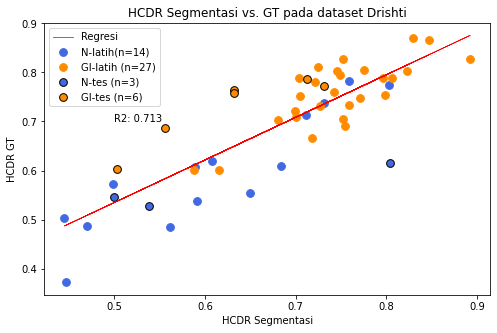

In [ ]:
abs_e = np.sum(abs(inf_df['HCDR GT'][dr_ts]-inf_df['HCDR'][dr_ts]))/len(dr_ts)
xo = inf_df['HCDR'][dr_n_tr]
yo = inf_df['HCDR GT'][dr_n_tr]
xi = inf_df['HCDR'][dr_gl_tr]
yi = inf_df['HCDR GT'][dr_gl_tr]
XO = inf_df['HCDR'][dr_n_ts]
YO = inf_df['HCDR GT'][dr_n_ts]
XI = inf_df['HCDR'][dr_gl_ts]
YI = inf_df['HCDR GT'][dr_gl_ts]

abs_e_dr = np.sum(abs(xo-yo))/len(xo)
abs_e_re = np.sum(abs(xi-yi))/len(xi)

x = inf_df['HCDR'][:50].to_numpy().reshape(-1, 1)
y = inf_df['HCDR GT'][:50].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))
plt.figure(figsize=(8, 5))
plt.scatter(xo, yo, s=60, marker='o', color='royalblue', label='N-latih(n={})'.format(len(xo)))
plt.scatter(xi, yi, s=60,marker='o', color='darkorange', label='Gl-latih (n={})'.format(len(xi)))
plt.scatter(XO, YO, s=60,marker='o', color='royalblue', edgecolors='k', label='N-tes (n={})'.format(len(XO)))
plt.scatter(XI, YI, s=60,marker='o', color='darkorange', edgecolors='k', label='Gl-tes (n={})'.format(len(XI)))
plt.plot(x, y_lin, color='r', label='Regresi', lw=0.75)
plt.ylabel('HCDR GT')
plt.xlabel('HCDR Segmentasi')
plt.title('HCDR Segmentasi vs. GT pada dataset Drishti')
plt.text(0.5, 0.7, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Absolute error in all cases: 0.12354
Absolute error in glaucoma cases: 0.02572
Absolute error in normal cases: 0.03455


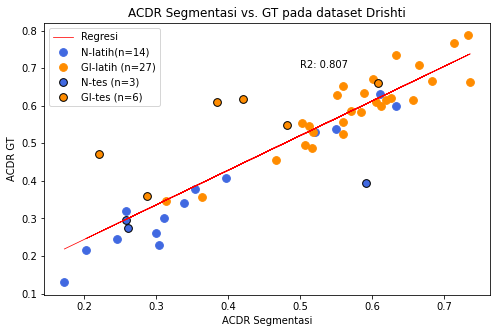

In [ ]:
abs_e = np.sum(abs(inf_df['ACDR GT'][dr_ts]-inf_df['ACDR'][dr_ts]))/len(dr_ts)
xo = inf_df['ACDR'][dr_n_tr]
yo = inf_df['ACDR GT'][dr_n_tr]
xi = inf_df['ACDR'][dr_gl_tr]
yi = inf_df['ACDR GT'][dr_gl_tr]
XO = inf_df['ACDR'][dr_n_ts]
YO = inf_df['ACDR GT'][dr_n_ts]
XI = inf_df['ACDR'][dr_gl_ts]
YI = inf_df['ACDR GT'][dr_gl_ts]

abs_e_dr = np.sum(abs(xo-yo))/len(xo)
abs_e_re = np.sum(abs(xi-yi))/len(xi)

x = inf_df['ACDR'][:50].to_numpy().reshape(-1, 1)
y = inf_df['ACDR GT'][:50].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))
plt.figure(figsize=(8, 5))
plt.scatter(xo, yo, s=60, marker='o', color='royalblue', label='N-latih(n={})'.format(len(xo)))
plt.scatter(xi, yi, s=60,marker='o', color='darkorange', label='Gl-latih (n={})'.format(len(xi)))
plt.scatter(XO, YO, s=60,marker='o', color='royalblue', edgecolors='k', label='N-tes (n={})'.format(len(XO)))
plt.scatter(XI, YI, s=60,marker='o', color='darkorange', edgecolors='k', label='Gl-tes (n={})'.format(len(XI)))
plt.plot(x, y_lin, color='r', label='Regresi', lw=0.75)
plt.ylabel('ACDR GT')
plt.xlabel('ACDR Segmentasi')
plt.title('ACDR Segmentasi vs. GT pada dataset Drishti')
plt.text(0.5, 0.7, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Fitur pada data refuge

Absolute error in all cases: 0.04682
Absolute error in glaucoma cases: 0.02814
Absolute error in normal cases: 0.02925


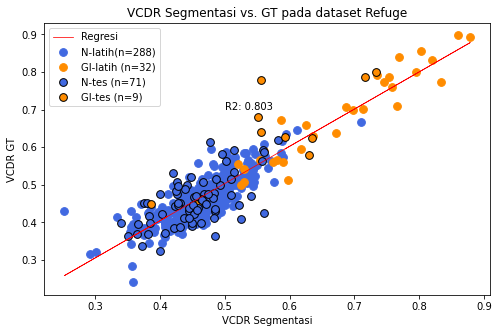

In [ ]:
abs_e = np.sum(abs(inf_df['VCDR GT'][re_ts]-inf_df['VCDR'][re_ts]))/len(re_ts)
xo = inf_df['VCDR'][re_n_tr]
yo = inf_df['VCDR GT'][re_n_tr]
xi = inf_df['VCDR'][re_gl_tr]
yi = inf_df['VCDR GT'][re_gl_tr]
XO = inf_df['VCDR'][re_n_ts]
YO = inf_df['VCDR GT'][re_n_ts]
XI = inf_df['VCDR'][re_gl_ts]
YI = inf_df['VCDR GT'][re_gl_ts]

abs_e_dr = np.sum(abs(xo-yo))/len(xo)
abs_e_re = np.sum(abs(xi-yi))/len(xi)

x = inf_df['VCDR'][50:].to_numpy().reshape(-1, 1)
y = inf_df['VCDR GT'][50:].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))
plt.figure(figsize=(8, 5))
plt.scatter(xo, yo, s=60, marker='o', color='royalblue', label='N-latih(n={})'.format(len(xo)))
plt.scatter(xi, yi, s=60,marker='o', color='darkorange', label='Gl-latih (n={})'.format(len(xi)))
plt.scatter(XO, YO, s=60,marker='o', color='royalblue', edgecolors='k', label='N-tes (n={})'.format(len(XO)))
plt.scatter(XI, YI, s=60,marker='o', color='darkorange', edgecolors='k', label='Gl-tes (n={})'.format(len(XI)))
plt.plot(x, y_lin, color='r', label='Regresi', lw=0.75)
plt.ylabel('VCDR GT')
plt.xlabel('VCDR Segmentasi')
plt.title('VCDR Segmentasi vs. GT pada dataset Refuge')
plt.text(0.5, 0.7, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Absolute error in all cases: 0.05997
Absolute error in glaucoma cases: 0.03114
Absolute error in normal cases: 0.03170


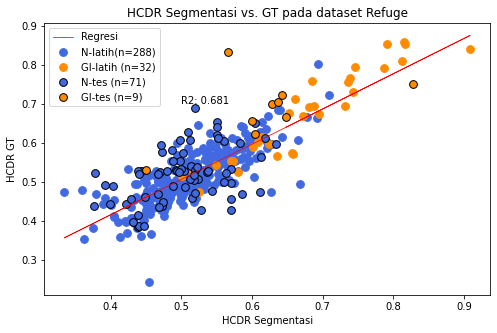

In [ ]:
abs_e = np.sum(abs(inf_df['HCDR GT'][re_ts]-inf_df['HCDR'][re_ts]))/len(re_ts)
xo = inf_df['HCDR'][re_n_tr]
yo = inf_df['HCDR GT'][re_n_tr]
xi = inf_df['HCDR'][re_gl_tr]
yi = inf_df['HCDR GT'][re_gl_tr]
XO = inf_df['HCDR'][re_n_ts]
YO = inf_df['HCDR GT'][re_n_ts]
XI = inf_df['HCDR'][re_gl_ts]
YI = inf_df['HCDR GT'][re_gl_ts]

abs_e_dr = np.sum(abs(xo-yo))/len(xo)
abs_e_re = np.sum(abs(xi-yi))/len(xi)

x = inf_df['HCDR'][50:].to_numpy().reshape(-1, 1)
y = inf_df['HCDR GT'][50:].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))
plt.figure(figsize=(8, 5))
plt.scatter(xo, yo, s=60, marker='o', color='royalblue', label='N-latih(n={})'.format(len(xo)))
plt.scatter(xi, yi, s=60,marker='o', color='darkorange', label='Gl-latih (n={})'.format(len(xi)))
plt.scatter(XO, YO, s=60,marker='o', color='royalblue', edgecolors='k', label='N-tes (n={})'.format(len(XO)))
plt.scatter(XI, YI, s=60,marker='o', color='darkorange', edgecolors='k', label='Gl-tes (n={})'.format(len(XI)))
plt.plot(x, y_lin, color='r', label='Regresi', lw=0.75)
plt.ylabel('HCDR GT')
plt.xlabel('HCDR Segmentasi')
plt.title('HCDR Segmentasi vs. GT pada dataset Refuge')
plt.text(0.5, 0.7, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Absolute error in all cases: 0.04531
Absolute error in glaucoma cases: 0.02173
Absolute error in normal cases: 0.03588


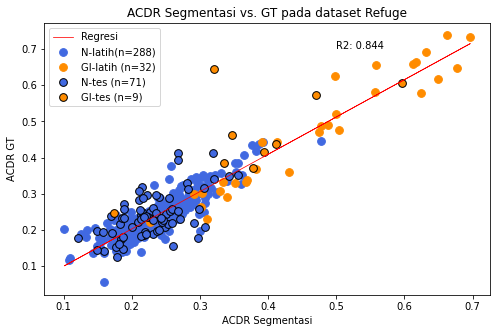

In [ ]:
abs_e = np.sum(abs(inf_df['ACDR GT'][re_ts]-inf_df['ACDR'][re_ts]))/len(re_ts)
xo = inf_df['ACDR'][re_n_tr]
yo = inf_df['ACDR GT'][re_n_tr]
xi = inf_df['ACDR'][re_gl_tr]
yi = inf_df['ACDR GT'][re_gl_tr]
XO = inf_df['ACDR'][re_n_ts]
YO = inf_df['ACDR GT'][re_n_ts]
XI = inf_df['ACDR'][re_gl_ts]
YI = inf_df['ACDR GT'][re_gl_ts]

abs_e_dr = np.sum(abs(xo-yo))/len(xo)
abs_e_re = np.sum(abs(xi-yi))/len(xi)

x = inf_df['ACDR'][50:].to_numpy().reshape(-1, 1)
y = inf_df['ACDR GT'][50:].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))
plt.figure(figsize=(8, 5))
plt.scatter(xo, yo, s=60, marker='o', color='royalblue', label='N-latih(n={})'.format(len(xo)))
plt.scatter(xi, yi, s=60,marker='o', color='darkorange', label='Gl-latih (n={})'.format(len(xi)))
plt.scatter(XO, YO, s=60,marker='o', color='royalblue', edgecolors='k', label='N-tes (n={})'.format(len(XO)))
plt.scatter(XI, YI, s=60,marker='o', color='darkorange', edgecolors='k', label='Gl-tes (n={})'.format(len(XI)))
plt.plot(x, y_lin, color='r', label='Regresi', lw=0.75)
plt.ylabel('ACDR GT')
plt.xlabel('ACDR Segmentasi')
plt.title('ACDR Segmentasi vs. GT pada dataset Refuge')
plt.text(0.5, 0.7, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Fitur pada seluruh data

Absolute error in all cases: 0.03311
Absolute error in glaucoma cases: 0.03135
Absolute error in normal cases: 0.04238


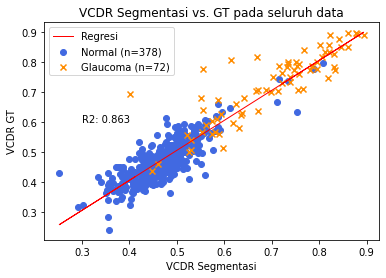

In [ ]:
abs_e = np.sum(abs(inf_df['VCDR GT']-inf_df['VCDR']))/ len(inf_df['VCDR'])
xo = inf_df.loc[inf_df['tag']=='Normal']['VCDR']
yo = inf_df.loc[inf_df['tag']=='Normal']['VCDR GT']
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df.loc[inf_df['tag']=='Glaucoma']['VCDR']
yi = inf_df.loc[inf_df['tag']=='Glaucoma']['VCDR GT']
abs_e_re = np.sum(abs(xi-yi))/len(xi)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))

x = inf_df['VCDR'].to_numpy().reshape(-1, 1)
y = inf_df['VCDR GT'].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

plt.scatter(xo, yo, marker='o', color='royalblue', label='Normal (n={})'.format(len(xo)))
plt.scatter(xi, yi, marker='x', color='darkorange', label='Glaucoma (n={})'.format(len(xi)))
plt.plot(x, y_lin, color='r', label='Regresi', lw=1)
plt.ylabel('VCDR GT')
plt.xlabel('VCDR Segmentasi')
plt.title('VCDR Segmentasi vs. GT pada seluruh data')
plt.text(0.3, 0.6, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Absolute error in all cases: 0.03835
Absolute error in glaucoma cases: 0.03698
Absolute error in normal cases: 0.04554


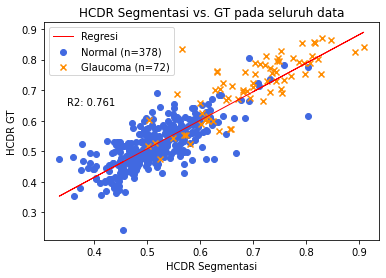

In [ ]:
abs_e = np.sum(abs(inf_df['HCDR GT']-inf_df['HCDR']))/ len(inf_df['HCDR'])
xo = inf_df.loc[inf_df['tag']=='Normal']['HCDR']
yo = inf_df.loc[inf_df['tag']=='Normal']['HCDR GT']
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df.loc[inf_df['tag']=='Glaucoma']['HCDR']
yi = inf_df.loc[inf_df['tag']=='Glaucoma']['HCDR GT']
abs_e_re = np.sum(abs(xi-yi))/len(xi)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))


x = inf_df['HCDR'].to_numpy().reshape(-1, 1)
y = inf_df['HCDR GT'].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

plt.scatter(xo, yo, marker='o', color='royalblue', label='Normal (n={})'.format(len(xo)))
plt.scatter(xi, yi, marker='x', color='darkorange', label='Glaucoma (n={})'.format(len(xi)))
plt.plot(x, y_lin, color='r', label='Regresi', lw=1)
plt.ylabel('HCDR GT')
plt.xlabel('HCDR Segmentasi')
plt.title('HCDR Segmentasi vs. GT pada seluruh data')
plt.text(0.35, 0.65, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

Absolute error in all cases: 0.02986
Absolute error in glaucoma cases: 0.02610
Absolute error in normal cases: 0.04961


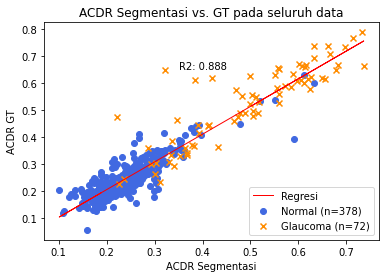

In [ ]:
abs_e = np.sum(abs(inf_df['ACDR GT']-inf_df['ACDR']))/ len(inf_df['ACDR'])
xo = inf_df.loc[inf_df['tag']=='Normal']['ACDR']
yo = inf_df.loc[inf_df['tag']=='Normal']['ACDR GT']
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df.loc[inf_df['tag']=='Glaucoma']['ACDR']
yi = inf_df.loc[inf_df['tag']=='Glaucoma']['ACDR GT']
abs_e_re = np.sum(abs(xi-yi))/len(xi)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))


x = inf_df['ACDR'].to_numpy().reshape(-1, 1)
y = inf_df['ACDR GT'].to_numpy().reshape(-1, 1)
y_lin = make_linear(x, y)
r2 = r_squared(x, y)

plt.scatter(xo, yo, marker='o', color='royalblue', label='Normal (n={})'.format(len(xo)))
plt.scatter(xi, yi, marker='x', color='darkorange', label='Glaucoma (n={})'.format(len(xi)))
plt.plot(x, y_lin, color='r', label='Regresi', lw=1)
plt.ylabel('ACDR GT')
plt.xlabel('ACDR Segmentasi')
plt.title('ACDR Segmentasi vs. GT pada seluruh data')
plt.text(0.35, 0.65, 'R2: {:.3f}'.format(r2))
plt.legend()
plt.show()

# **Limit of Agreement**

GT number vs. GT mask

GT mask vs. Segmentation

In [ ]:
inf_df.columns

Index(['VCDR Gold', 'VCDR', 'HCDR', 'ACDR', 'VCDR GT', 'HCDR GT', 'ACDR GT',
       'ver OD GT', 'ver OC GT', 'ver OD seg', 'ver OC seg', 'hor OD GT',
       'hor OC GT', 'hor OD seg', 'hor OC seg', 'area OD GT', 'area OC GT',
       'area OD seg', 'area OC seg', 'tag'],
      dtype='object')

In [ ]:
def retrieve_data(inf_df, data, dataset):
  if dataset=='drishti':
    gl_ix = [x for x in range(50) if x < 32]
    n_ix = [x for x in range(50) if x >= 32]
  elif dataset == 'refuge':
    gl_ix = [x for x in range(50, 450) if x < 90]
    n_ix = [x for x in range(50, 450) if x >= 90]

  x1 = inf_df[data+ ' seg'][n_ix]
  y1 = inf_df[data+ ' GT'][n_ix]
  x2 = inf_df[data+ ' seg'][gl_ix]
  y2 = inf_df[data + ' GT'][gl_ix]

  return x1, y1, x2, y2


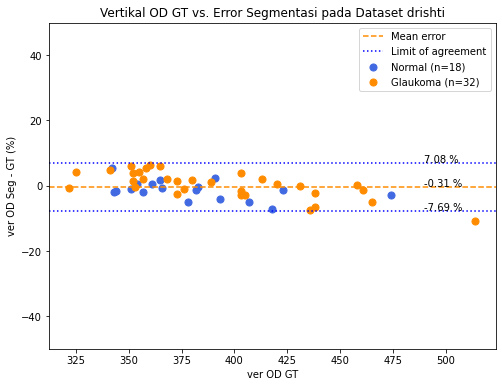

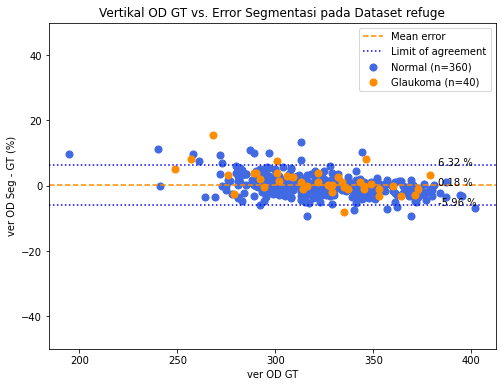

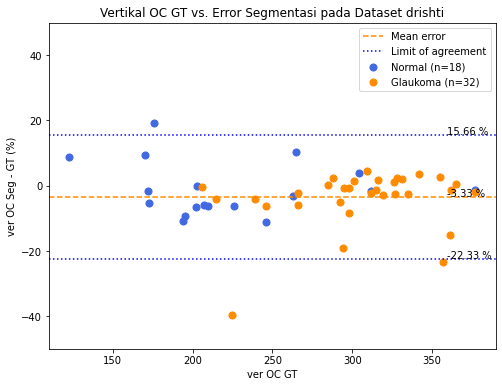

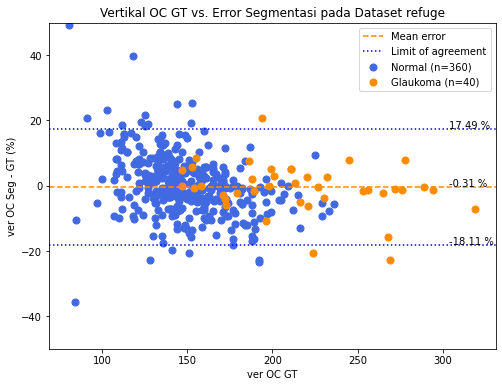

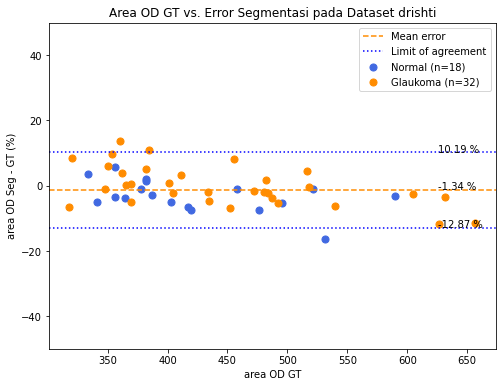

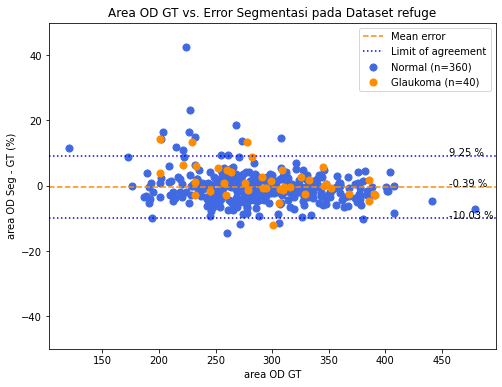

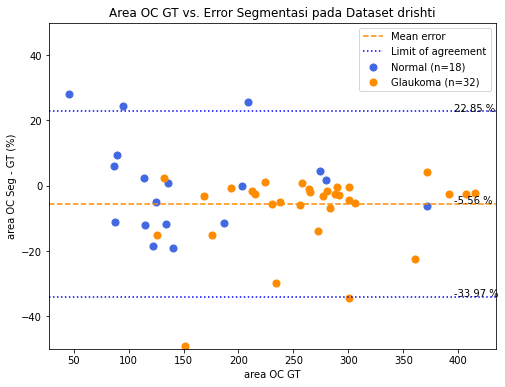

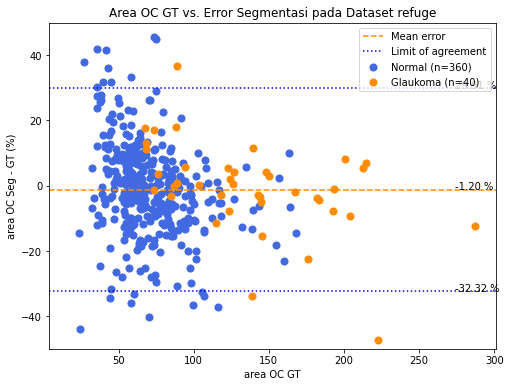

In [ ]:
CDRs = ['ver OD', 'ver OC', 'area OD', 'area OC']
datasets = ['drishti', 'refuge']
for CDR in CDRs:
  for dataset in datasets:
    
    xo, yo, xi, yi = retrieve_data(inf_df, CDR, dataset)
    diff1 = yo - xo
    diff2 = yi - xi
    if np.max(yi) > np.max(yo):
      dx = np.max(yi)-(1/21)*np.max(yi)
    else:
      dx = np.max(yo)-(1/21)*np.max(yo)

    diff_p1 = np.divide(diff1, yo)*-100
    diff_p2 = np.divide(diff2, yi)*-100
    if dataset == 'drishti':
      ix = range(50)
    else:
      ix = range(50, 450)
    val1 = inf_df[CDR + ' GT'][ix].to_numpy()
    val2 = inf_df[CDR + ' seg'][ix].to_numpy()
    diff = val1 - val2
    rata2 = (val1 + val2) /2
    diff_p = np.divide(diff, rata2)*-100
    mean = np.mean(diff_p)
    std = np.std(diff_p)
    fitur = CDR.split(' ')
    if fitur[0] =='ver':
      fitur[0] = 'Vertikal'
    else:
      fitur[0] = 'Area'
    fitur = fitur[0] + ' ' + fitur[1]
    plt.figure(figsize=(8, 6))
    plt.scatter(yo, diff_p1, s=50, color='royalblue', label='Normal (n={})'.format(len(xo)))
    plt.scatter(yi, diff_p2, s=50, color='darkorange', label='Glaukoma (n={})'.format(len(xi)))

    plt.axhline(mean, color = 'darkorange', linestyle = '--', label = 'Mean error')
    plt.axhline(mean + 1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
    plt.axhline(mean - 1.95*std, color = 'b', linestyle = ':')

    plt.text(dx, mean + 0.05, '{:.2f} %'.format(mean), size='medium')
    plt.text(dx, mean + 1.95*std + 0.05, '{:.2f} %'.format(mean + 1.95*std), size='medium')
    plt.text(dx, mean - 1.95*std + 0.05, '{:.2f} %'.format(mean - 1.95*std), size='medium')
    plt.legend()
    plt.title('{} GT vs. Error Segmentasi pada Dataset {}'.format(fitur, dataset))
    labely = CDR + ' Seg - GT (%)'
    labelx = CDR + ' GT'
    plt.ylabel(labely)
    plt.xlabel(labelx)
    plt.ylim(-50, 50)
    plt.show()

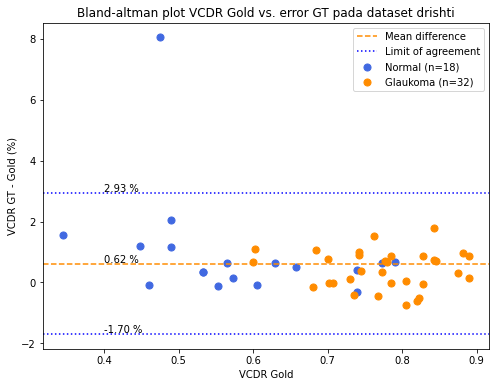

In [ ]:
CDR = 'VCDR'
dataset = 'drishti'
dx = 0.4
xo = inf_df['VCDR GT'][dr_n_ix]
yo = inf_df['VCDR Gold'][dr_n_ix]
xi = inf_df['VCDR GT'][dr_gl_ix]
yi = inf_df['VCDR Gold'][dr_gl_ix]
diff1 = yo - xo
diff2 = yi - xi


diff_p1 = np.divide(diff1, yo)*-100
diff_p2 = np.divide(diff2, yi)*-100

val1 = inf_df[CDR + ' Gold'][:50].to_numpy()
val2 = inf_df[CDR + ' GT'][:50].to_numpy()
diff = val1 - val2
rata2 = (val1 + val2) /2
diff_p = np.divide(diff, rata2)*-100
mean = np.mean(diff_p)
std = np.std(diff_p)

plt.figure(figsize=(8, 6))
plt.scatter(yo, diff_p1, s=50, color='royalblue', label='Normal (n={})'.format(len(xo)))
plt.scatter(yi, diff_p2, s=50, color='darkorange', label='Glaukoma (n={})'.format(len(xi)))

plt.axhline(mean, color = 'darkorange', linestyle = '--', label = 'Mean difference')
plt.axhline(mean + 1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.axhline(mean - 1.95*std, color = 'b', linestyle = ':')

plt.text(dx, mean + 0.05, '{:.2f} %'.format(mean), size='medium')
plt.text(dx, mean + 1.95*std + 0.05, '{:.2f} %'.format(mean + 1.95*std), size='medium')
plt.text(dx, mean - 1.95*std + 0.05, '{:.2f} %'.format(mean - 1.95*std), size='medium')
plt.legend()
plt.title('Bland-altman plot {} Gold vs. error GT pada dataset {}'.format(CDR, dataset))
labely = CDR + ' GT - Gold (%)'
labelx = CDR + ' Gold'
plt.ylabel(labely)
plt.xlabel(labelx)
plt.show()

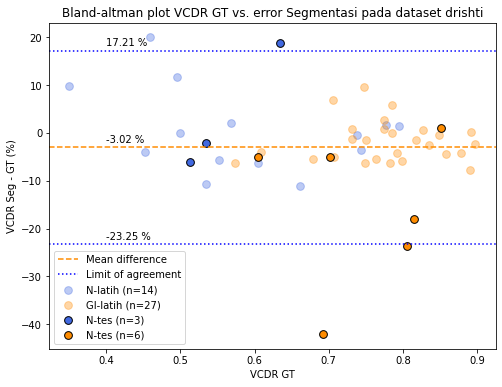

In [ ]:
CDR = 'VCDR'
dataset = 'drishti'
dx = 0.4
x1, y1, x2, y2, x3, y3, x4, y4 = retrieve_cdr(inf_df, CDR, dataset)
diff1 = y1 - x1
diff2 = y2 - x2
diff3 = y3 - x3
diff4 = y4 - x4

diff_p1 = np.divide(diff1, y1)*-100
diff_p2 = np.divide(diff2, y2)*-100
diff_p3 = np.divide(diff3, y3)*-100
diff_p4 = np.divide(diff4, y4)*-100

val1 = inf_df[CDR + ' GT'][:50].to_numpy()
val2 = inf_df[CDR][:50].to_numpy()
diff = val1 - val2
rata2 = (val1 + val2) /2
diff_p = np.divide(diff, rata2)*-100
mean = np.mean(diff_p)
std = np.std(diff_p)

plt.figure(figsize=(8, 6))
plt.scatter(y1, diff_p1, s=60, color='royalblue', alpha=0.35, label='N-latih (n={})'.format(len(x1)))
plt.scatter(y2, diff_p2, s=60, color='darkorange', alpha=0.35, label='Gl-latih (n={})'.format(len(x2)))
plt.scatter(y3, diff_p3, s=60, edgecolors='k', color='royalblue', label='N-tes (n={})'.format(len(x3)))
plt.scatter(y4, diff_p4, s=60, edgecolors='k', color='darkorange', label='N-tes (n={})'.format(len(x4)))
plt.axhline(mean, color = 'darkorange', linestyle = '--', label = 'Mean difference')
plt.axhline(mean + 1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.axhline(mean - 1.95*std, color = 'b', linestyle = ':')

plt.text(dx, mean + 1, '{:.2f} %'.format(mean), size='medium')
plt.text(dx, mean + 1.95*std  + 1, '{:.2f} %'.format(mean + 1.95*std), size='medium')
plt.text(dx, mean - 1.95*std + 1, '{:.2f} %'.format(mean - 1.95*std), size='medium')
plt.legend()
plt.title('Bland-altman plot {} GT vs. error Segmentasi pada dataset {}'.format(CDR, dataset))
labely = CDR + ' Seg - GT (%)'
labelx = CDR + ' GT'
plt.ylabel(labely)
plt.xlabel(labelx)
plt.show()

Text(0.5, 1.0, 'Error Pengukuran Fitur Turunan CDR Data Refuge-Glaukoma')

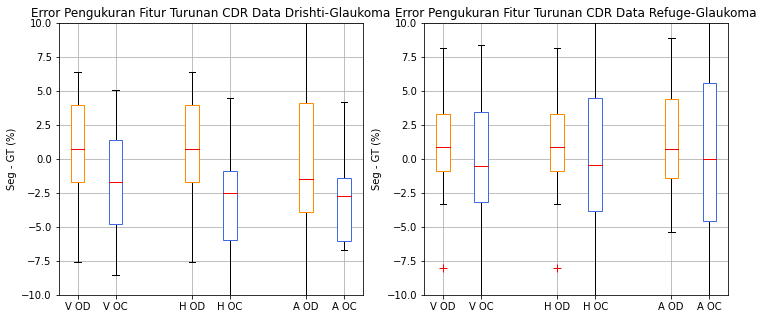

In [ ]:
error_ver_OD_dr = np.divide(inf_df['ver OD GT'][dr_gl_ix] - inf_df['ver OD seg'][dr_gl_ix], inf_df['ver OD GT'][dr_gl_ix])*-100
error_hor_OD_dr = np.divide(inf_df['hor OD GT'][dr_gl_ix]  - inf_df['hor OD seg'][dr_gl_ix], inf_df['hor OD GT'][dr_gl_ix])*-100
error_area_OD_dr = np.divide(inf_df['area OD GT'][dr_gl_ix]  - inf_df['area OD seg'][dr_gl_ix], inf_df['area OD GT'][dr_gl_ix])*-100
error_ver_OC_dr = np.divide(inf_df['ver OC GT'][dr_gl_ix]  - inf_df['ver OC seg'][dr_gl_ix], inf_df['hor OC GT'][dr_gl_ix])*-100
error_hor_OC_dr = np.divide(inf_df['hor OC GT'][dr_gl_ix]  - inf_df['hor OC seg'][dr_gl_ix], inf_df['ver OC GT'][dr_gl_ix])*-100
error_area_OC_dr = np.divide(inf_df['area OC GT'][dr_gl_ix]  - inf_df['area OC seg'][dr_gl_ix], inf_df['area OC GT'][dr_gl_ix])*-100
error_ver_OD_re = np.divide(inf_df['ver OD GT'][re_gl_ix] - inf_df['ver OD seg'][re_gl_ix], inf_df['ver OD GT'][re_gl_ix])*-100
error_hor_OD_re = np.divide(inf_df['hor OD GT'][re_gl_ix]  - inf_df['hor OD seg'][re_gl_ix], inf_df['hor OD GT'][re_gl_ix])*-100
error_area_OD_re = np.divide(inf_df['area OD GT'][re_gl_ix]  - inf_df['area OD seg'][re_gl_ix], inf_df['area OD GT'][re_gl_ix])*-100
error_ver_OC_re = np.divide(inf_df['ver OC GT'][re_gl_ix]  - inf_df['ver OC seg'][re_gl_ix], inf_df['ver OC GT'][re_gl_ix])*-100
error_hor_OC_re = np.divide(inf_df['hor OC GT'][re_gl_ix]  - inf_df['hor OC seg'][re_gl_ix], inf_df['hor OC GT'][re_gl_ix])*-100
error_area_OC_re = np.divide(inf_df['area OC GT'][re_gl_ix]  - inf_df['area OC seg'][re_gl_ix], inf_df['area OC GT'][re_gl_ix])*-100

plt.figure(figsize=(12, 5))
flierprops = dict(marker='+', markerfacecolor='g', markersize=8,
                  linestyle='none', markeredgecolor='r')
glprops = dict(color='darkorange', facecolor='w')
nprops = dict(color='royalblue',facecolor='w')
medianprops=dict(color='r')
data_OD_dr = [error_ver_OD_dr, error_ver_OD_dr, error_area_OD_dr]
data_OC_dr = [error_ver_OC_dr, error_hor_OC_dr,error_area_OC_dr]

data_OD_re = [error_ver_OD_re, error_ver_OD_re, error_area_OD_re]
data_OC_re = [error_ver_OC_re, error_hor_OC_re,error_area_OC_re]

plt.subplot(1,2,1), 
plt.boxplot(data_OD_dr, positions=[1, 4, 7], widths=0.35, flierprops=flierprops, boxprops=glprops, medianprops=medianprops, patch_artist=True)
plt.boxplot(data_OC_dr, positions=[2, 5, 8], widths=0.35,flierprops=flierprops, boxprops=nprops, medianprops=medianprops, patch_artist=True)
plt.grid()
plt.ylabel('Seg - GT (%)')
plt.ylim(-10, 10)
# plt.axhline(0.52, color = 'r', linestyle = '--', label = 'threshold')
plt.xticks([1, 2, 4, 5, 7, 8], labels=['V OD', 'V OC', 'H OD', 'H OC',
                                 'A OD', 'A OC',])
plt.title('Error Pengukuran Fitur Turunan CDR Data Drishti-Glaukoma')

plt.subplot(1,2,2)
plt.boxplot(data_OD_re, positions=[1, 4, 7], widths=0.35, flierprops=flierprops, boxprops=glprops, medianprops=medianprops, patch_artist=True)
plt.boxplot(data_OC_re, positions=[2, 5, 8], widths=0.35,flierprops=flierprops, boxprops=nprops, medianprops=medianprops, patch_artist=True)
plt.grid()
plt.ylabel('Seg - GT (%)')
plt.ylim(-10, 10)
# plt.axhline(0.52, color = 'r', linestyle = '--', label = 'threshold')
plt.xticks([1, 2, 4, 5, 7, 8], labels=['V OD', 'V OC', 'H OD', 'H OC',
                                 'A OD', 'A OC',])
plt.title('Error Pengukuran Fitur Turunan CDR Data Refuge-Glaukoma')


Text(0.5, 1.0, 'Error Pengukuran Fitur Turunan CDR Refuge-Normal')

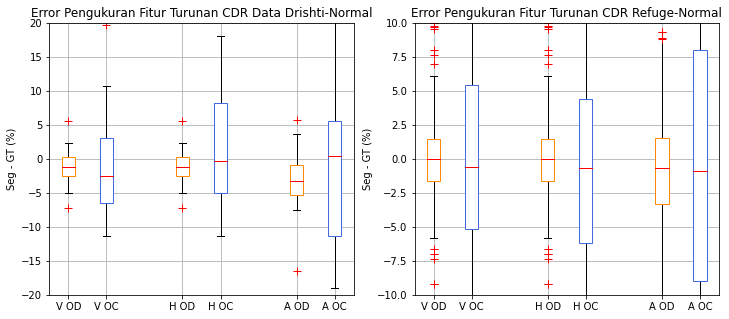

In [ ]:
error_ver_OD_dr = np.divide(inf_df['ver OD GT'][dr_n_ix] - inf_df['ver OD seg'][dr_n_ix], inf_df['ver OD GT'][dr_n_ix])*-100
error_hor_OD_dr = np.divide(inf_df['hor OD GT'][dr_n_ix]  - inf_df['hor OD seg'][dr_n_ix], inf_df['hor OD GT'][dr_n_ix])*-100
error_area_OD_dr = np.divide(inf_df['area OD GT'][dr_n_ix]  - inf_df['area OD seg'][dr_n_ix], inf_df['area OD GT'][dr_n_ix])*-100
error_ver_OC_dr = np.divide(inf_df['ver OC GT'][dr_n_ix]  - inf_df['ver OC seg'][dr_n_ix], inf_df['hor OC GT'][dr_n_ix])*-100
error_hor_OC_dr = np.divide(inf_df['hor OC GT'][dr_n_ix]  - inf_df['hor OC seg'][dr_n_ix], inf_df['ver OC GT'][dr_n_ix])*-100
error_area_OC_dr = np.divide(inf_df['area OC GT'][dr_n_ix]  - inf_df['area OC seg'][dr_n_ix], inf_df['area OC GT'][dr_n_ix])*-100
error_ver_OD_re = np.divide(inf_df['ver OD GT'][re_n_ix] - inf_df['ver OD seg'][re_n_ix], inf_df['ver OD GT'][re_n_ix])*-100
error_hor_OD_re = np.divide(inf_df['hor OD GT'][re_n_ix]  - inf_df['hor OD seg'][re_n_ix], inf_df['hor OD GT'][re_n_ix])*-100
error_area_OD_re = np.divide(inf_df['area OD GT'][re_n_ix]  - inf_df['area OD seg'][re_n_ix], inf_df['area OD GT'][re_n_ix])*-100
error_ver_OC_re = np.divide(inf_df['ver OC GT'][re_n_ix]  - inf_df['ver OC seg'][re_n_ix], inf_df['ver OC GT'][re_n_ix])*-100
error_hor_OC_re = np.divide(inf_df['hor OC GT'][re_n_ix]  - inf_df['hor OC seg'][re_n_ix], inf_df['hor OC GT'][re_n_ix])*-100
error_area_OC_re = np.divide(inf_df['area OC GT'][re_n_ix]  - inf_df['area OC seg'][re_n_ix], inf_df['area OC GT'][re_n_ix])*-100

plt.figure(figsize=(12, 5))
flierprops = dict(marker='+', markerfacecolor='g', markersize=8,
                  linestyle='none', markeredgecolor='r')
glprops = dict(color='darkorange', facecolor='w')
nprops = dict(color='royalblue',facecolor='w')
medianprops=dict(color='r')
data_OD_dr = [error_ver_OD_dr, error_ver_OD_dr, error_area_OD_dr]
data_OC_dr = [error_ver_OC_dr, error_hor_OC_dr,error_area_OC_dr]

data_OD_re = [error_ver_OD_re, error_ver_OD_re, error_area_OD_re]
data_OC_re = [error_ver_OC_re, error_hor_OC_re,error_area_OC_re]

plt.subplot(1,2,1), 
plt.boxplot(data_OD_dr, positions=[1, 4, 7], widths=0.35, flierprops=flierprops, boxprops=glprops, medianprops=medianprops, patch_artist=True)
plt.boxplot(data_OC_dr, positions=[2, 5, 8], widths=0.35,flierprops=flierprops, boxprops=nprops, medianprops=medianprops, patch_artist=True)
plt.grid()
plt.ylabel('Seg - GT (%)')
plt.ylim(-20, 20)
# plt.axhline(0.52, color = 'r', linestyle = '--', label = 'threshold')
plt.xticks([1, 2, 4, 5, 7, 8], labels=['V OD', 'V OC', 'H OD', 'H OC',
                                 'A OD', 'A OC',])
plt.title('Error Pengukuran Fitur Turunan CDR Data Drishti-Normal')

plt.subplot(1,2,2)
plt.boxplot(data_OD_re, positions=[1, 4, 7], widths=0.35, flierprops=flierprops, boxprops=glprops, medianprops=medianprops, patch_artist=True)
plt.boxplot(data_OC_re, positions=[2, 5, 8], widths=0.35,flierprops=flierprops, boxprops=nprops, medianprops=medianprops, patch_artist=True)
plt.grid()
plt.ylabel('Seg - GT (%)')
plt.ylim(-10, 10)
# plt.axhline(0.52, color = 'r', linestyle = '--', label = 'threshold')
plt.xticks([1, 2, 4, 5, 7, 8], labels=['V OD', 'V OC', 'H OD', 'H OC',
                                 'A OD', 'A OC',])
plt.title('Error Pengukuran Fitur Turunan CDR Refuge-Normal')


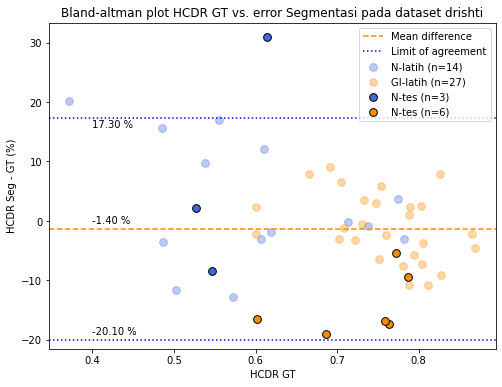

In [ ]:
CDR = 'HCDR'
dataset = 'drishti'
dx = 0.4
x1, y1, x2, y2, x3, y3, x4, y4 = retrieve_cdr(inf_df, CDR, dataset)
diff1 = y1 - x1
diff2 = y2 - x2
diff3 = y3 - x3
diff4 = y4 - x4

diff_p1 = np.divide(diff1, y1)*-100
diff_p2 = np.divide(diff2, y2)*-100
diff_p3 = np.divide(diff3, y3)*-100
diff_p4 = np.divide(diff4, y4)*-100

val1 = inf_df[CDR + ' GT'][:50].to_numpy()
val2 = inf_df[CDR][:50].to_numpy()
diff = val1 - val2
rata2 = (val1 + val2) /2
diff_p = np.divide(diff, rata2)*-100
mean = np.mean(diff_p)
std = np.std(diff_p)

plt.figure(figsize=(8, 6))
plt.scatter(y1, diff_p1, s=60, color='royalblue', alpha=0.35, label='N-latih (n={})'.format(len(x1)))
plt.scatter(y2, diff_p2, s=60, color='darkorange', alpha=0.35, label='Gl-latih (n={})'.format(len(x2)))
plt.scatter(y3, diff_p3, s=60, edgecolors='k', color='royalblue', label='N-tes (n={})'.format(len(x3)))
plt.scatter(y4, diff_p4, s=60, edgecolors='k', color='darkorange', label='N-tes (n={})'.format(len(x4)))
plt.axhline(mean, color = 'darkorange', linestyle = '--', label = 'Mean difference')
plt.axhline(mean + 1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.axhline(mean - 1.95*std, color = 'b', linestyle = ':')

plt.text(dx, mean + 1, '{:.2f} %'.format(mean), size='medium')
plt.text(dx, mean + 1.95*std  - 1.6, '{:.2f} %'.format(mean + 1.95*std), size='medium')
plt.text(dx, mean - 1.95*std + 1, '{:.2f} %'.format(mean - 1.95*std), size='medium')
plt.legend()
plt.title('Bland-altman plot {} GT vs. error Segmentasi pada dataset {}'.format(CDR, dataset))
labely = CDR + ' Seg - GT (%)'
labelx = CDR + ' GT'
plt.ylabel(labely)
plt.xlabel(labelx)
plt.show()

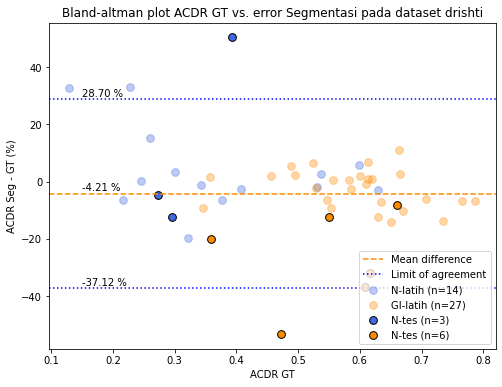

In [ ]:
CDR = 'ACDR'
dataset = 'drishti'
dx = 0.15
x1, y1, x2, y2, x3, y3, x4, y4 = retrieve_cdr(inf_df, CDR, dataset)
diff1 = y1 - x1
diff2 = y2 - x2
diff3 = y3 - x3
diff4 = y4 - x4

diff_p1 = np.divide(diff1, y1)*-100
diff_p2 = np.divide(diff2, y2)*-100
diff_p3 = np.divide(diff3, y3)*-100
diff_p4 = np.divide(diff4, y4)*-100

val1 = inf_df[CDR + ' GT'][:50].to_numpy()
val2 = inf_df[CDR][:50].to_numpy()
diff = val1 - val2
rata2 = (val1 + val2) /2
diff_p = np.divide(diff, rata2)*-100
mean = np.mean(diff_p)
std = np.std(diff_p)

plt.figure(figsize=(8, 6))
plt.scatter(y1, diff_p1, s=60, color='royalblue', alpha=0.35, label='N-latih (n={})'.format(len(x1)))
plt.scatter(y2, diff_p2, s=60, color='darkorange', alpha=0.35, label='Gl-latih (n={})'.format(len(x2)))
plt.scatter(y3, diff_p3, s=60, edgecolors='k', color='royalblue', label='N-tes (n={})'.format(len(x3)))
plt.scatter(y4, diff_p4, s=60, edgecolors='k', color='darkorange', label='N-tes (n={})'.format(len(x4)))
plt.axhline(mean, color = 'darkorange', linestyle = '--', label = 'Mean difference')
plt.axhline(mean + 1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.axhline(mean - 1.95*std, color = 'b', linestyle = ':')

plt.text(dx, mean + 1, '{:.2f} %'.format(mean), size='medium')
plt.text(dx, mean + 1.95*std  + 1, '{:.2f} %'.format(mean + 1.95*std), size='medium')
plt.text(dx, mean - 1.95*std + 1, '{:.2f} %'.format(mean - 1.95*std), size='medium')
plt.legend(loc='lower right')
plt.title('Bland-altman plot {} GT vs. error Segmentasi pada dataset {}'.format(CDR, dataset))
labely = CDR + ' Seg - GT (%)'
labelx = CDR + ' GT'
plt.ylabel(labely)
plt.xlabel(labelx)
plt.show()

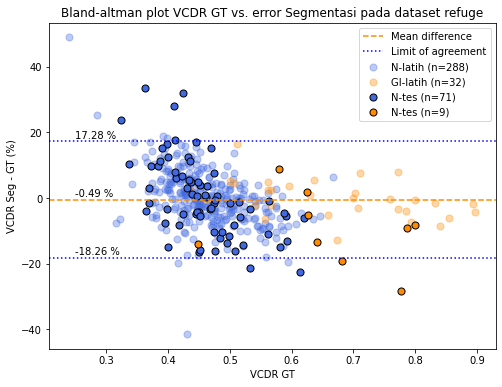

In [ ]:
CDR = 'VCDR'
dataset = 'refuge'
dx = 0.25
x1, y1, x2, y2, x3, y3, x4, y4 = retrieve_cdr(inf_df, CDR, dataset)
diff1 = y1 - x1
diff2 = y2 - x2
diff3 = y3 - x3
diff4 = y4 - x4

diff_p1 = np.divide(diff1, y1)*-100
diff_p2 = np.divide(diff2, y2)*-100
diff_p3 = np.divide(diff3, y3)*-100
diff_p4 = np.divide(diff4, y4)*-100

val1 = inf_df[CDR + ' GT'][50:].to_numpy()
val2 = inf_df[CDR][50:].to_numpy()
diff = val1 - val2
rata2 = (val1 + val2) /2
diff_p = np.divide(diff, rata2)*-100
mean = np.mean(diff_p)
std = np.std(diff_p)

plt.figure(figsize=(8, 6))
plt.scatter(y1, diff_p1, s=50, color='royalblue', alpha=0.35, label='N-latih (n={})'.format(len(x1)))
plt.scatter(y2, diff_p2, s=50, color='darkorange', alpha=0.35, label='Gl-latih (n={})'.format(len(x2)))
plt.scatter(y3, diff_p3, s=50, edgecolors='k', color='royalblue', label='N-tes (n={})'.format(len(x3)))
plt.scatter(y4, diff_p4, s=50, edgecolors='k', color='darkorange', label='N-tes (n={})'.format(len(x4)))
plt.axhline(mean, color = 'darkorange', linestyle = '--', label = 'Mean difference')
plt.axhline(mean + 1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.axhline(mean - 1.95*std, color = 'b', linestyle = ':')

plt.text(dx, mean + 1, '{:.2f} %'.format(mean), size='medium')
plt.text(dx, mean + 1.95*std  + 1, '{:.2f} %'.format(mean + 1.95*std), size='medium')
plt.text(dx, mean - 1.95*std + 1, '{:.2f} %'.format(mean - 1.95*std), size='medium')
plt.legend()
plt.title('Bland-altman plot {} GT vs. error Segmentasi pada dataset {}'.format(CDR, dataset))
labely = CDR + ' Seg - GT (%)'
labelx = CDR + ' GT'
plt.ylabel(labely)
plt.xlabel(labelx)
plt.show()

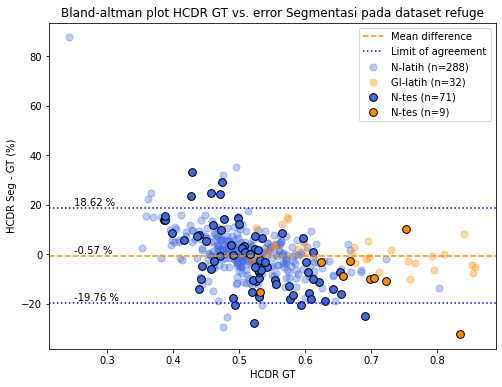

In [ ]:
CDR = 'HCDR'
dataset = 'refuge'
dx = 0.25
x1, y1, x2, y2, x3, y3, x4, y4 = retrieve_cdr(inf_df, CDR, dataset)
diff1 = y1 - x1
diff2 = y2 - x2
diff3 = y3 - x3
diff4 = y4 - x4

diff_p1 = np.divide(diff1, y1)*-100
diff_p2 = np.divide(diff2, y2)*-100
diff_p3 = np.divide(diff3, y3)*-100
diff_p4 = np.divide(diff4, y4)*-100

val1 = inf_df[CDR + ' GT'][50:].to_numpy()
val2 = inf_df[CDR][50:].to_numpy()
diff = val1 - val2
rata2 = (val1 + val2) /2
diff_p = np.divide(diff, rata2)*-100
mean = np.mean(diff_p)
std = np.std(diff_p)

plt.figure(figsize=(8, 6))
plt.scatter(y1, diff_p1, s=50, color='royalblue', alpha=0.35, label='N-latih (n={})'.format(len(x1)))
plt.scatter(y2, diff_p2, s=50, color='darkorange', alpha=0.35, label='Gl-latih (n={})'.format(len(x2)))
plt.scatter(y3, diff_p3, s=60, edgecolors='k', color='royalblue', label='N-tes (n={})'.format(len(x3)))
plt.scatter(y4, diff_p4, s=60, edgecolors='k', color='darkorange', label='N-tes (n={})'.format(len(x4)))
plt.axhline(mean, color = 'darkorange', linestyle = '--', label = 'Mean difference')
plt.axhline(mean + 1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.axhline(mean - 1.95*std, color = 'b', linestyle = ':')

plt.text(dx, mean + 1, '{:.2f} %'.format(mean), size='medium')
plt.text(dx, mean + 1.95*std  + 1, '{:.2f} %'.format(mean + 1.95*std), size='medium')
plt.text(dx, mean - 1.95*std + 1, '{:.2f} %'.format(mean - 1.95*std), size='medium')
plt.legend()
plt.title('Bland-altman plot {} GT vs. error Segmentasi pada dataset {}'.format(CDR, dataset))
labely = CDR + ' Seg - GT (%)'
labelx = CDR + ' GT'
plt.ylabel(labely)
plt.xlabel(labelx)
plt.show()

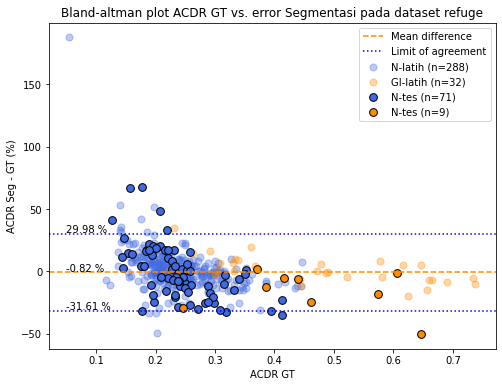

In [ ]:
CDR = 'ACDR'
dataset = 'refuge'
dx = 0.05
x1, y1, x2, y2, x3, y3, x4, y4 = retrieve_cdr(inf_df, CDR, dataset)
diff1 = y1 - x1
diff2 = y2 - x2
diff3 = y3 - x3
diff4 = y4 - x4

diff_p1 = np.divide(diff1, y1)*-100
diff_p2 = np.divide(diff2, y2)*-100
diff_p3 = np.divide(diff3, y3)*-100
diff_p4 = np.divide(diff4, y4)*-100

val1 = inf_df[CDR + ' GT'][50:].to_numpy()
val2 = inf_df[CDR][50:].to_numpy()
diff = val1 - val2
rata2 = (val1 + val2) /2
diff_p = np.divide(diff, rata2)*-100
mean = np.mean(diff_p)
std = np.std(diff_p)

plt.figure(figsize=(8, 6))
plt.scatter(y1, diff_p1, s=50, color='royalblue', alpha=0.35, label='N-latih (n={})'.format(len(x1)))
plt.scatter(y2, diff_p2, s=50, color='darkorange', alpha=0.35, label='Gl-latih (n={})'.format(len(x2)))
plt.scatter(y3, diff_p3, s=60, edgecolors='k', color='royalblue', label='N-tes (n={})'.format(len(x3)))
plt.scatter(y4, diff_p4, s=60, edgecolors='k', color='darkorange', label='N-tes (n={})'.format(len(x4)))
plt.axhline(mean, color = 'darkorange', linestyle = '--', label = 'Mean difference')
plt.axhline(mean + 1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.axhline(mean - 1.95*std, color = 'b', linestyle = ':')

plt.text(dx, mean + 1, '{:.2f} %'.format(mean), size='medium')
plt.text(dx, mean + 1.95*std  + 1, '{:.2f} %'.format(mean + 1.95*std), size='medium')
plt.text(dx, mean - 1.95*std + 1, '{:.2f} %'.format(mean - 1.95*std), size='medium')
plt.legend()
plt.title('Bland-altman plot {} GT vs. error Segmentasi pada dataset {}'.format(CDR, dataset))
labely = CDR + ' Seg - GT (%)'
labelx = CDR + ' GT'
plt.ylabel(labely)
plt.xlabel(labelx)
plt.show()

# Glaucoma Inference

In [ ]:
inf_df.groupby(['tag']).size()

tag
Glaucoma     72
Normal      378
dtype: int64

In [13]:
data = 'seluruh data'
if data=='refuge':
  train_ix, test_ix = index_shuffle(f=2)
  train_ix = train_ix[train_ix >= 50]
  test_ix = test_ix[test_ix >= 50]
else:
  train_ix, test_ix = index_shuffle(f=2)

In [14]:
x1a= inf_df[['VCDR']].to_numpy()
x1b= inf_df[['HCDR']].to_numpy()
x1c= inf_df[['ACDR']].to_numpy()
x2a = inf_df[['VCDR', 'ACDR']].to_numpy()
x2b = inf_df[['VCDR', 'HCDR']].to_numpy()
x2c = inf_df[['ACDR', 'HCDR']].to_numpy()
x3 = inf_df[['VCDR', 'ACDR', 'HCDR']].to_numpy()

x_GT1a = inf_df[['VCDR GT']].to_numpy()
x_GT1b = inf_df[['HCDR GT']].to_numpy()
x_GT1c = inf_df[['ACDR GT']].to_numpy()
x_GT2a = inf_df[['VCDR GT', 'ACDR GT']].to_numpy()
x_GT2b = inf_df[['VCDR GT', 'HCDR GT']].to_numpy()
x_GT2c = inf_df[['ACDR GT', 'HCDR GT']].to_numpy()
x_GT3 = inf_df[['VCDR GT', 'ACDR GT', 'HCDR GT']].to_numpy()

y = inf_df['tag'].to_numpy()
y = encoder(y)

In [15]:
# optimasi hyperparameter
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf1a = GridSearchCV(LogisticRegression(solver='lbfgs', class_weight='balanced'), param_grid)
clf1b = GridSearchCV(LogisticRegression(solver='lbfgs', class_weight='balanced'), param_grid)
clf1c = GridSearchCV(LogisticRegression(solver='lbfgs', class_weight='balanced'), param_grid)
clf2a = GridSearchCV(LogisticRegression(solver='lbfgs', class_weight='balanced'), param_grid)
clf2b = GridSearchCV(LogisticRegression(solver='lbfgs', class_weight='balanced'), param_grid)
clf2c = GridSearchCV(LogisticRegression(solver='lbfgs', class_weight='balanced'), param_grid)
clf3 = GridSearchCV(LogisticRegression(solver='lbfgs', class_weight='balanced'), param_grid)

clf1a.fit(x_GT1a[train_ix], y[train_ix])
clf1b.fit(x_GT1b[train_ix], y[train_ix])
clf1c.fit(x_GT1c[train_ix], y[train_ix])
clf2a.fit(x_GT2a[train_ix], y[train_ix])
clf2b.fit(x_GT2b[train_ix], y[train_ix])
clf2c.fit(x_GT2c[train_ix], y[train_ix])
clf3.fit(x_GT3[train_ix], y[train_ix])

print('Logistic Regression 1a: ',clf1a.best_params_)
print('Logistic Regression 1b: ',clf1b.best_params_)
print('Logistic Regression 1c: ',clf1c.best_params_)
print('Logistic Regression 2a: ',clf2a.best_params_)
print('Logistic Regression 2b: ',clf2b.best_params_)
print('Logistic Regression 2c: ',clf2c.best_params_)
print('Logistic Regression 3: ',clf3.best_params_)


Logistic Regression 1a:  {'C': 0.001}
Logistic Regression 1b:  {'C': 0.001}
Logistic Regression 1c:  {'C': 0.001}
Logistic Regression 2a:  {'C': 0.001}
Logistic Regression 2b:  {'C': 0.001}
Logistic Regression 2c:  {'C': 1}
Logistic Regression 3:  {'C': 1}


Logistic 1a: Acc = 0.955
Logistic 2a: Acc = 0.933
Logistic 2b: Acc = 0.955
Logistic 3: Acc = 0.955



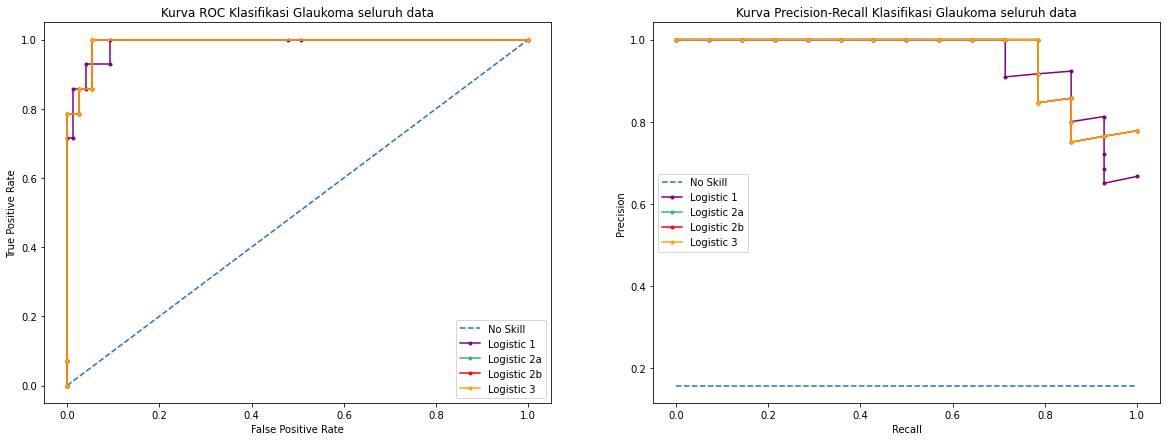

No Skill: ROC AUC=0.500
Logistic 1a: ROC AUC=0.989
Logistic 2a: ROC AUC=0.990
Logistic 2b: ROC AUC=0.990
Logistic 3: ROC AUC=0.990
No Skill: PR AUC=0.157
Logistic 1a: PR AUC=0.950
Logistic 2a: PR AUC=0.956
Logistic 2b: PR AUC=0.956
Logistic 3: PR AUC=0.956


In [16]:
# split into train/test sets
trainy = y[train_ix]
testy = y[test_ix]
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

# fit a model
model1a = LogisticRegression(solver='lbfgs', class_weight='balanced', C=0.001)
model2a = LogisticRegression(solver='lbfgs', class_weight='balanced', C=0.001)
model2b = LogisticRegression(solver='lbfgs',class_weight='balanced',  C=0.001)
model3 = LogisticRegression(solver='lbfgs', class_weight='balanced', C=1)

model1a.fit(x_GT1a[train_ix], trainy)
model2a.fit(x_GT2a[train_ix], trainy)
model2b.fit(x_GT2b[train_ix], trainy)
model3.fit(x_GT3[train_ix], trainy)

# predict probabilities
lr1a_probs = model1a.predict_proba(x_GT1a[test_ix])
lr2a_probs = model2a.predict_proba(x_GT2a[test_ix])
lr2b_probs = model2b.predict_proba(x_GT2b[test_ix])
lr3_probs = model3.predict_proba(x_GT3[test_ix])
# predict class

# thd1a = threshold_pred(x_GT1a[test_ix], 0.56)
lr1a = model1a.predict(x_GT1a[test_ix])
lr2a = model2a.predict(x_GT2a[test_ix])
lr2b = model2b.predict(x_GT2b[test_ix])
lr3 = model3.predict(x_GT3[test_ix])

# Calculate accuracy
# acc0a = accuracy_score(testy, thd1a)
acc1a = accuracy_score(testy, lr1a)
acc2a = accuracy_score(testy, lr2a)
acc2b = accuracy_score(testy, lr2b)
acc3 = accuracy_score(testy, lr3)

# summarize scores
# print('Threshold 1a: Acc = %.3f' % (acc0a))
print('Logistic 1a: Acc = %.3f' % (acc1a))
print('Logistic 2a: Acc = %.3f' % (acc2a))
print('Logistic 2b: Acc = %.3f' % (acc2b))
print('Logistic 3: Acc = %.3f' % (acc3))
print()

# keep probabilities for the positive outcome only
lr1a_probs = lr1a_probs[:, 1]
lr2a_probs = lr2a_probs[:, 1]
lr2b_probs = lr2b_probs[:, 1]
lr3_probs = lr3_probs[:, 1]

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr1a_fpr, lr1a_tpr, _ = roc_curve(testy, lr1a_probs)
lr2a_fpr, lr2a_tpr, _ = roc_curve(testy, lr2a_probs)
lr2b_fpr, lr2b_tpr, _ = roc_curve(testy, lr2b_probs)
lr3_fpr, lr3_tpr, _ = roc_curve(testy, lr3_probs)
# cdra_fpr, cdra_tpr, _ = roc_curve(testy, x_GT1a[test_ix])

# calculate precision-recall curve
ns_precision, ns_recall, _ = precision_recall_curve(testy, ns_probs)
lr1a_precision, lr1a_recall, _ = precision_recall_curve(testy, lr1a_probs)
lr2a_precision, lr2a_recall, _ = precision_recall_curve(testy, lr2a_probs)
lr2b_precision, lr2b_recall, _ = precision_recall_curve(testy, lr2b_probs)
lr3_precision, lr3_recall, _ = precision_recall_curve(testy, lr3_probs)
# cdra_precision, cdra_recall, _ = precision_recall_curve(testy, x_GT1a[test_ix])

# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr1a_auc = roc_auc_score(testy, lr1a_probs)
lr2a_auc = roc_auc_score(testy, lr2a_probs)
lr2b_auc = roc_auc_score(testy, lr2b_probs)
lr3_auc = roc_auc_score(testy, lr3_probs)
# vcdra_auc = roc_auc_score(testy, x_GT1a[test_ix])

# calculate scores
no_skill = len(testy[testy==1]) / len(testy)
lr1a_auc_pr = auc(lr1a_recall, lr1a_precision)
lr2a_auc_pr = auc(lr2a_recall, lr2a_precision)
lr2b_auc_pr = auc(lr2b_recall, lr2b_precision)
lr3_auc_pr = auc(lr3_recall, lr3_precision)
# cdra_auc_pr = auc(cdra_recall,cdra_precision)


# plot the roc curve for the model
plt.figure(figsize=(20, 7))
plt.subplot(1,2,1),
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# plt.plot(cdra_fpr, cdra_tpr, marker='.', label='Threshold', color='darkgray')
plt.plot(lr1a_fpr, lr1a_tpr, marker='.', label='Logistic 1', color='purple')
plt.plot(lr2a_fpr, lr2a_tpr, marker='.', label='Logistic 2a', color='mediumseagreen')
plt.plot(lr2b_fpr, lr2b_tpr, marker='.', label='Logistic 2b', color='r')
plt.plot(lr3_fpr, lr3_tpr, marker='.', label='Logistic 3', color='orange')
plt.title('Kurva ROC Klasifikasi Glaukoma {}'.format(data))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# plot the PR curve for the model
plt.subplot(1,2,2),
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# plt.plot(cdra_recall, cdra_precision, marker='.', label='Threshold', color='darkgray')
plt.plot(lr1a_recall, lr1a_precision, marker='.', label='Logistic 1', color='purple')
plt.plot(lr2a_recall, lr2a_precision, marker='.', label='Logistic 2a', color='mediumseagreen')
plt.plot(lr2b_recall, lr2b_precision, marker='.', label='Logistic 2b', color='r')
plt.plot(lr3_recall, lr3_precision, marker='.', label='Logistic 3', color='orange')
plt.title('Kurva Precision-Recall Klasifikasi Glaukoma {}'.format(data))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()



# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic 1a: ROC AUC=%.3f' % (lr1a_auc))
print('Logistic 2a: ROC AUC=%.3f' % (lr2a_auc))
print('Logistic 2b: ROC AUC=%.3f' % (lr2b_auc))
print('Logistic 3: ROC AUC=%.3f' % (lr3_auc))
# print('Threshold 1a: ROC AUC=%.3f' % (cdra_auc))

# summarize scores
print('No Skill: PR AUC=%.3f' % (no_skill))
print('Logistic 1a: PR AUC=%.3f' % (lr1a_auc_pr))
print('Logistic 2a: PR AUC=%.3f' % (lr2a_auc_pr))
print('Logistic 2b: PR AUC=%.3f' % (lr2b_auc_pr))
print('Logistic 3: PR AUC=%.3f' % (lr3_auc_pr))
# print('Threshold 1a: PR AUC=%.3f' % (cdra_auc_pr))



In [17]:
# predict class
thd1a = threshold_pred(x1a[test_ix])
#thd1b = threshold_pred(x1b[test_ix])
#thd1c = threshold_pred(x1c[test_ix])
lr1a = model1a.predict(x1a[test_ix])
#lr1b = model1b.predict(x1b[test_ix])
#lr1c = model1c.predict(x1c[test_ix])
lr2a = model2a.predict(x2a[test_ix])
lr2b = model2b.predict(x2b[test_ix])
#lr2c = model2c.predict(x2c[test_ix])
lr3 = model3.predict(x3[test_ix])

# Calculate accuracy
acc0a = accuracy_score(testy, thd1a)
#acc0b = accuracy_score(testy, thd1b)
#acc0c = accuracy_score(testy, thd1c)
acc1a = accuracy_score(testy, lr1a)
#acc1b = accuracy_score(testy, lr1b)
#acc1c = accuracy_score(testy, lr1c)
acc2a = accuracy_score(testy, lr2a)
acc2b = accuracy_score(testy, lr2b)
#acc2c = accuracy_score(testy, lr2c)
acc3 = accuracy_score(testy, lr3)

# summarize scores
print('Threshold 1a: Acc = %.3f' % (acc0a))
#print('Threshold 1b: Acc = %.3f' % (acc0b))
#print('Threshold 1c: Acc = %.3f' % (acc0c))
print('Logistic 1a: Acc = %.3f' % (acc1a))
#print('Logistic 1b: Acc = %.3f' % (acc1b))
#print('Logistic 1c: Acc = %.3f' % (acc1c))
print('Logistic 2a: Acc = %.3f' % (acc2a))
print('Logistic 2b: Acc = %.3f' % (acc2b))
#print('Logistic 2c: Acc = %.3f' % (acc2c))
print('Logistic 3: Acc = %.3f' % (acc3))
print()

Threshold 1a: Acc = 0.921
Logistic 1a: Acc = 0.921
Logistic 2a: Acc = 0.933
Logistic 2b: Acc = 0.933
Logistic 3: Acc = 0.933



In [20]:
import pickle
# save the best model

best_model = model2a # Pick the best model from analysis process
file_path = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Model/Inference model/inference_model.sav'
pickle.dump(best_model, open(file_path, 'wb'))

In [ ]:
y_pred = threshold_pred(x_GT1a[re_ts], threshold=0.54)
y_true = y[re_ts]
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
acc, sen, spe, f, youden = metrik(tn, fp, fn, tp)
print(acc)
print(sen)
print(spe)
print(youden)

0.9
1.0
0.8888888888888888
0.8888888888888888


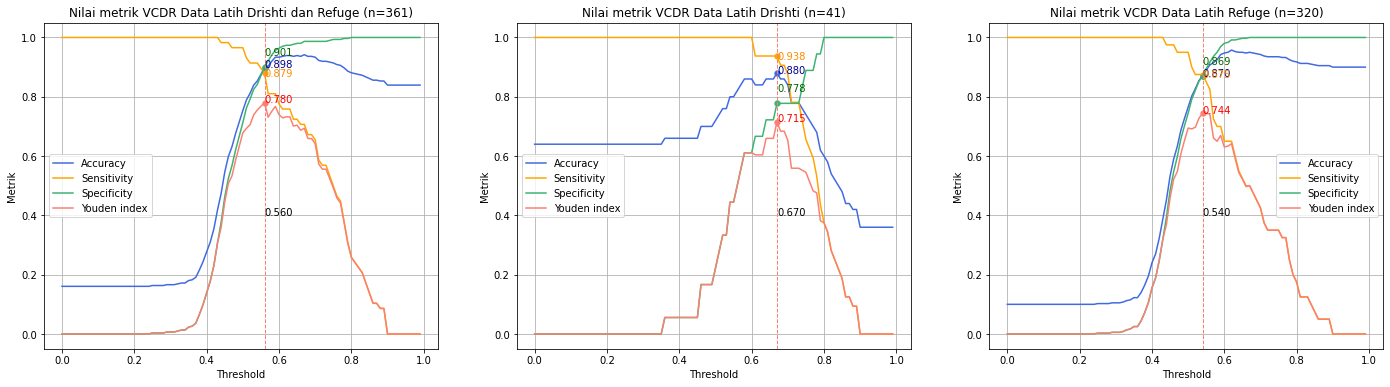

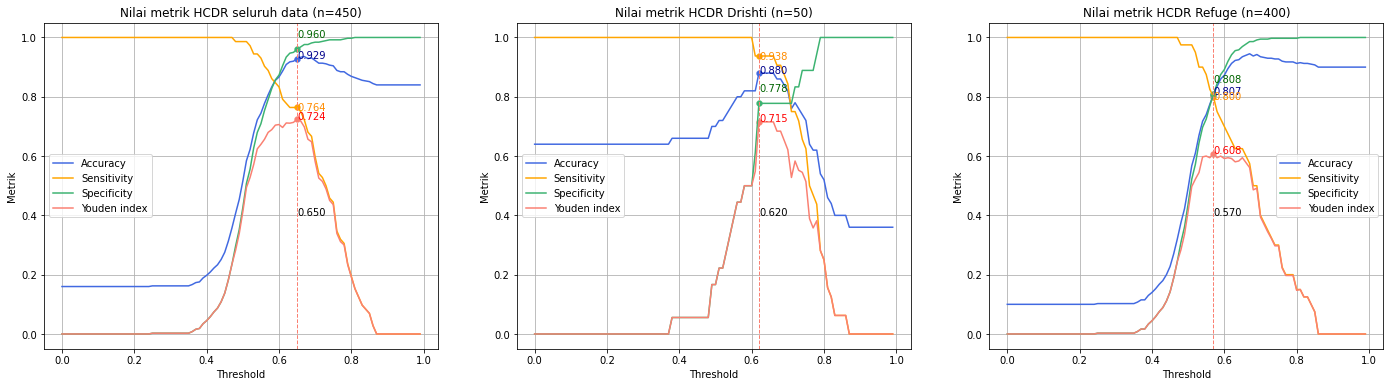

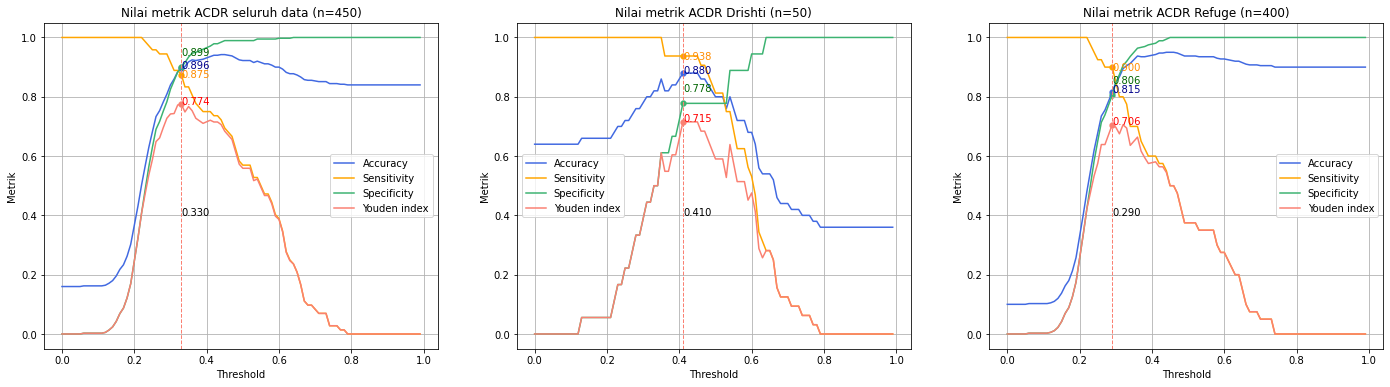

In [ ]:
x = x_GT1a

fitur = 'VCDR'
thd, acc_all, sen_all, spe_all, youd_all = all_threshold_metric(x[train_ix], y[train_ix])
_, acc_dr, sen_dr, spe_dr, youd_dr = all_threshold_metric(x[:50], y[:50])
_, acc_re, sen_re, spe_re, youd_re = all_threshold_metric(x[50:], y[50:])
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
plot_metrik_threshold(thd, acc_all, sen_all, spe_all, youd_all, ax, 0, fitur, 'Data Latih Drishti dan Refuge', n=len(train_ix))
plot_metrik_threshold(thd, acc_dr, sen_dr, spe_dr, youd_dr, ax, 1, fitur, 'Data Latih Drishti', n=len(dr_tr))
plot_metrik_threshold(thd, acc_re, sen_re, spe_re, youd_re, ax, 2, fitur, 'Data Latih Refuge', n=len(re_tr))
plt.show()

x = x_GT1b
fitur = 'HCDR'
thd, acc_all, sen_all, spe_all, youd_all = all_threshold_metric(x, y)
_, acc_dr, sen_dr, spe_dr, youd_dr = all_threshold_metric(x[:50], y[:50])
_, acc_re, sen_re, spe_re, youd_re = all_threshold_metric(x[50:], y[50:])
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
plot_metrik_threshold(thd, acc_all, sen_all, spe_all, youd_all, ax, 0, fitur, 'seluruh data', n=450)
plot_metrik_threshold(thd, acc_dr, sen_dr, spe_dr, youd_dr, ax, 1, fitur, 'Drishti', n=50)
plot_metrik_threshold(thd, acc_re, sen_re, spe_re, youd_re, ax, 2, fitur, 'Refuge', n=400)
plt.show()

x = x_GT1c
fitur = 'ACDR'
thd, acc_all, sen_all, spe_all, youd_all = all_threshold_metric(x, y)
_, acc_dr, sen_dr, spe_dr, youd_dr = all_threshold_metric(x[:50], y[:50])
_, acc_re, sen_re, spe_re, youd_re = all_threshold_metric(x[50:], y[50:])
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
plot_metrik_threshold(thd, acc_all, sen_all, spe_all, youd_all, ax, 0, fitur, 'seluruh data', n=450)
plot_metrik_threshold(thd, acc_dr, sen_dr, spe_dr, youd_dr, ax, 1, fitur, 'Drishti', n=50)
plot_metrik_threshold(thd, acc_re, sen_re, spe_re, youd_re, ax, 2, fitur, 'Refuge', n=400)
plt.show()



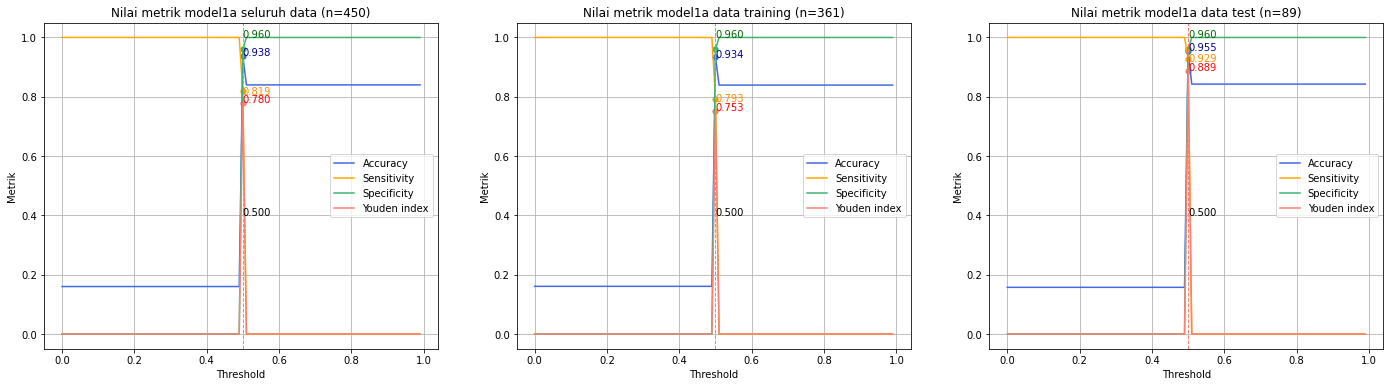

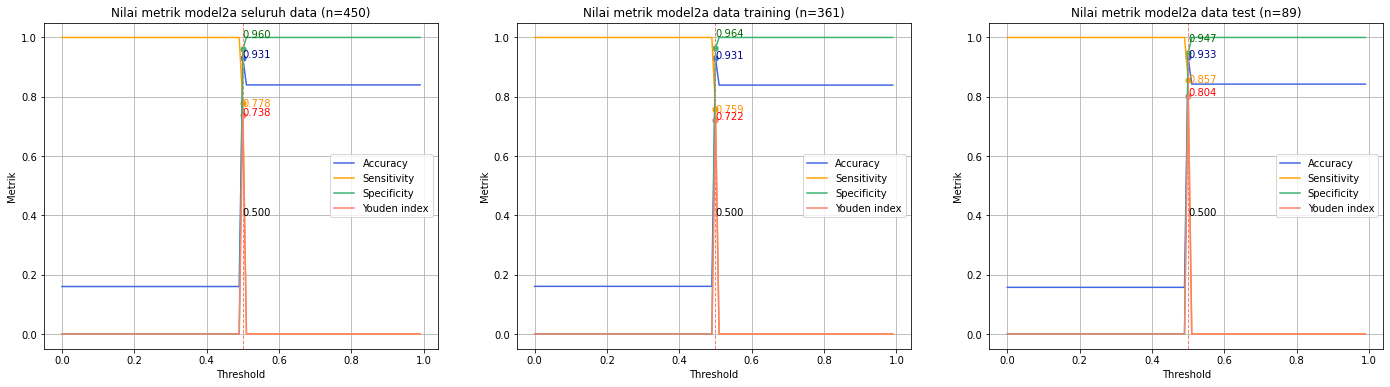

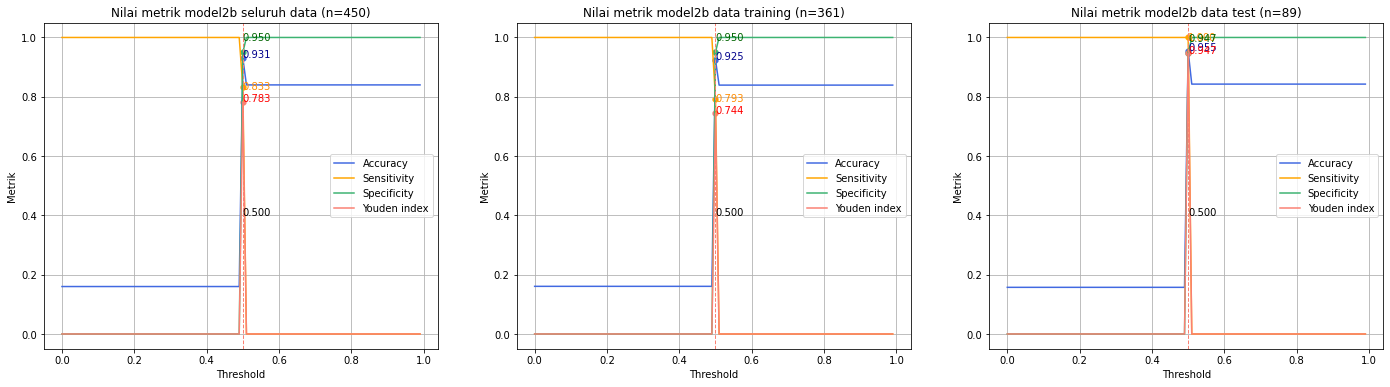

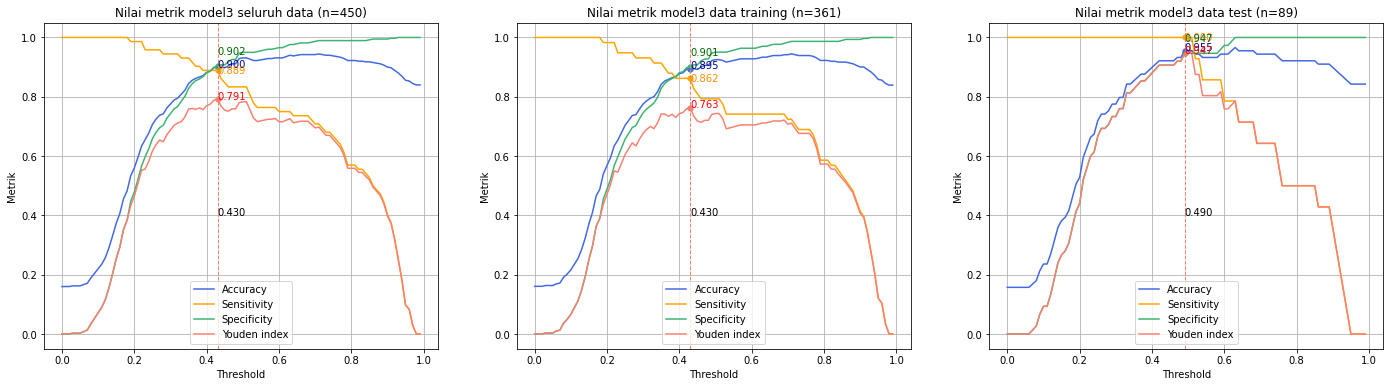

In [ ]:
x = model1a.predict_proba(x_GT1a)[:, 1]
fitur = 'model1a'
thd, acc_all, sen_all, spe_all, youd_all = all_threshold_metric(x, y)
_, acc_dr, sen_dr, spe_dr, youd_dr = all_threshold_metric(x[train_ix], y[train_ix])
_, acc_re, sen_re, spe_re, youd_re = all_threshold_metric(x[test_ix], y[test_ix])
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
plot_metrik_threshold(thd, acc_all, sen_all, spe_all, youd_all, ax, 0, fitur, 'seluruh data', n=450)
plot_metrik_threshold(thd, acc_dr, sen_dr, spe_dr, youd_dr, ax, 1, fitur, 'data training', n=361)
plot_metrik_threshold(thd, acc_re, sen_re, spe_re, youd_re, ax, 2, fitur, 'data test', n=89)
plt.show()

x = model2a.predict_proba(x_GT2a)[:, 1]
fitur = 'model2a'
thd, acc_all, sen_all, spe_all, youd_all = all_threshold_metric(x, y)
_, acc_dr, sen_dr, spe_dr, youd_dr = all_threshold_metric(x[train_ix], y[train_ix])
_, acc_re, sen_re, spe_re, youd_re = all_threshold_metric(x[test_ix], y[test_ix])
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
plot_metrik_threshold(thd, acc_all, sen_all, spe_all, youd_all, ax, 0, fitur, 'seluruh data', n=450)
plot_metrik_threshold(thd, acc_dr, sen_dr, spe_dr, youd_dr, ax, 1, fitur, 'data training', n=361)
plot_metrik_threshold(thd, acc_re, sen_re, spe_re, youd_re, ax, 2, fitur, 'data test', n=89)
plt.show()

x = model2b.predict_proba(x_GT2b)[:, 1]
fitur = 'model2b'
thd, acc_all, sen_all, spe_all, youd_all = all_threshold_metric(x, y)
_, acc_dr, sen_dr, spe_dr, youd_dr = all_threshold_metric(x[train_ix], y[train_ix])
_, acc_re, sen_re, spe_re, youd_re = all_threshold_metric(x[test_ix], y[test_ix])
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
plot_metrik_threshold(thd, acc_all, sen_all, spe_all, youd_all, ax, 0, fitur, 'seluruh data', n=450)
plot_metrik_threshold(thd, acc_dr, sen_dr, spe_dr, youd_dr, ax, 1, fitur, 'data training', n=361)
plot_metrik_threshold(thd, acc_re, sen_re, spe_re, youd_re, ax, 2, fitur, 'data test', n=89)
plt.show()

x = model3.predict_proba(x_GT3)[:, 1]
fitur = 'model3'
thd, acc_all, sen_all, spe_all, youd_all = all_threshold_metric(x, y)
_, acc_dr, sen_dr, spe_dr, youd_dr = all_threshold_metric(x[train_ix], y[train_ix])
_, acc_re, sen_re, spe_re, youd_re = all_threshold_metric(x[test_ix], y[test_ix])
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
plot_metrik_threshold(thd, acc_all, sen_all, spe_all, youd_all, ax, 0, fitur, 'seluruh data', n=450)
plot_metrik_threshold(thd, acc_dr, sen_dr, spe_dr, youd_dr, ax, 1, fitur, 'data training', n=361)
plot_metrik_threshold(thd, acc_re, sen_re, spe_re, youd_re, ax, 2, fitur, 'data test', n=89)
plt.show()

In [ ]:
def plot_cfm(cfm, ax, i, metode):
  im = ax[i].imshow(cfm, cmap='summer')
  classes = ['Normal', 'Glaucoma']
  # We want to show all ticks...
  ax[i].set_xticks(np.arange(len(classes)))
  ax[i].set_yticks(np.arange(len(classes)))
  # ... and label them with the respective list entries
  ax[i].set_xticklabels(classes)
  ax[i].set_yticklabels(classes)
  ax[i].set_xlabel('Prediksi')
  ax[i].set_ylabel('Label')
  # Rotate the tick labels and set their alignment.
  plt.setp(ax[i].get_yticklabels(), rotation=90, ha="center",
          rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  for x in range(len(classes)):
      for y in range(len(classes)):
          text = ax[i].text(y, x, cfm[x, y],
                        ha="center", va="center", color="k", size='x-large')

  ax[i].set_title("Confusion Matrix {}".format(metode))

# Confusion matrix
def confusion_m(y_pred, y_true, train_ix, test_ix, dataset):
  if dataset=='Drishti':
    cfm1 = confusion_matrix(y_true[:50], y_pred[:50])
  elif dataset=='Refuge':
    cfm1 = confusion_matrix(y_true[50:], y_pred[50:])
  
  cfm2 = confusion_matrix(y_true[train_ix], y_pred[train_ix])
  cfm3 = confusion_matrix(y_true[test_ix], y_pred[test_ix])
  tn1, fp1, fn1, tp1 = cfm1.ravel()
  tn2, fp2, fn2, tp2 = cfm2.ravel()
  tn3, fp3, fn3, tp3 = cfm3.ravel()
  acc1, sen1, spe1, f1, _ = metrik(tn1, fp1, fn1, tp1)
  acc2, sen2, spe2, f2, _ = metrik(tn2, fp2, fn2, tp2)
  acc3, sen3, spe3, f3, _ = metrik(tn3, fp3, fn3, tp3)
  
  
  fig, ax = plt.subplots(1,3, figsize=(12, 4))
  plot_cfm(cfm1, ax, 0, metode='Seluruh Data {}'.format(dataset))
  plot_cfm(cfm2, ax, 1, metode='Data Train {}'.format(dataset))
  plot_cfm(cfm3, ax, 2, metode='Data Tes {}'.format(dataset))
  fig.tight_layout()
  plt.show()
  print('Seluruh data  | Train      | Test')
  print('Acc 1: {:.3f}  | Acc 2: {:.3f} | Acc 3: {:.3f}'.format(acc1, acc2, acc3))
  print('Sen 1: {:.3f}  | Sen 2: {:.3f} | Sen 3: {:.3f}'.format(sen1, sen2, sen3))
  print('Spe 1: {:.3f}  | Spe 2: {:.3f} | Spe 3: {:.3f}'.format(spe1, spe2, spe3))
  print('F1   : {:.3f}  | F2   : {:.3f} | F3   : {:.3f}'.format(f1, f2, f3))

In [ ]:
mean_gl = np.mean(inf_df['ACDR GT'][dr_gl_ix])
std_gl = np.std(inf_df['ACDR GT'][dr_gl_ix])
mean_n = np.mean(inf_df['ACDR GT'][dr_n_ix])
std_n = np.std(inf_df['ACDR GT'][dr_n_ix])
print(mean_gl)
print(std_gl)
print(mean_n)
print(std_n)

0.5910484263406248
0.09849139178988371
0.3574736572111112
0.13447934414341653


In [ ]:
def plot_CDR(CDR, T, dataset):
  if dataset.lower() == 'drishti':
    n_ix = dr_n_ix
    gl_ix = dr_gl_ix
  elif dataset.lower() == 'refuge':
    n_ix = re_n_ix
    gl_ix = re_gl_ix
  
  yo1 = inf_df[CDR+ ' GT'][n_ix]
  yo2 = inf_df[CDR][n_ix]
  zipped_yo = zip(yo1, yo2)
  sorted_zipped_yo = sorted(zipped_yo)
  yo1 = [element for element,_ in sorted_zipped_yo]
  yo2 = [element for _,element in sorted_zipped_yo]
  xo = list(range(0, len(yo1)))


  yi1 = inf_df[CDR+ ' GT'][gl_ix]
  yi2 = inf_df[CDR][gl_ix]
  zipped_yi = zip(yi1, yi2)
  sorted_zipped_yi = sorted(zipped_yi)
  yi1 = [element for element,_ in sorted_zipped_yi]
  yi2 = [element for _,element in sorted_zipped_yi]

  xi = list(range(len(yo1),len(yo1) + len(yi1)))
  mean_gl = np.mean(yi1)
  std_gl = np.std(yi1)
  mean_n = np.mean(yo1)
  std_n = np.std(yo1)
  upper_bound = mean_gl - std_gl
  lower_bound = mean_n + std_n
  #plt.scatter(xo, yo1, c='g', marker='o', label='Norm GT')
  #plt.scatter(xo, yo2, c='mediumseagreen', marker='x', label='Norm Seg')
  plt.scatter(xi, yi1, c='r', marker='o', label = 'Gl GT')
  plt.scatter(xi, yi2, c='salmon', marker='x', label = 'Gl Seg')
  #plt.axhline(y=T)
  plt.xlabel('Data')
  plt.ylabel(CDR)
  #plt.axhline(y=upper_bound, c='r')
  #plt.axhline(y=lower_bound, c='g')
  plt.ylim(0, 1)
  #plt.text(x=np.max(xi)*0.9, y=T+0.02, s='T = {:.2f}'.format(T))
  plt.title('Profil {} glaukoma dataset {}'.format(CDR, dataset))
  plt.legend()
  #plt.text(x=5, y=upper_bound+0.02, s='T = {:.2f}'.format(upper_bound))
  #plt.text(x=40, y=lower_bound+0.02, s='T = {:.2f}'.format(lower_bound))
  

In [ ]:
@interact(T=(0, 100))
def plot(T=0):
  t = T/100
  plt.figure(figsize=(13, 5))
  plt.subplot(1,2,1),
  plot_CDR('VCDR', t, 'drishti')
  plt.subplot(1,2,2),
  plot_CDR('ACDR', t, 'refuge')


interactive(children=(IntSlider(value=0, description='T'), Output()), _dom_classes=('widget-interact',))

Thresholding


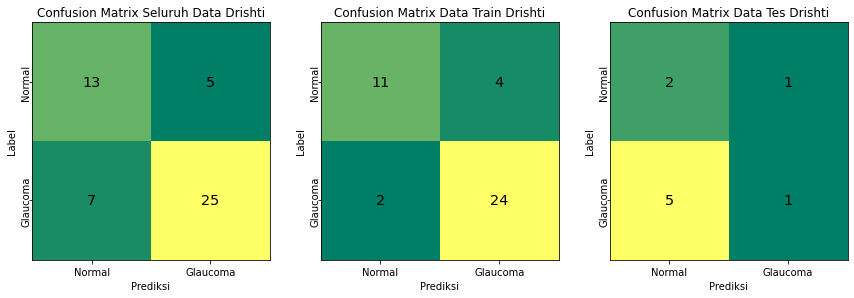

Seluruh data  | Train      | Test
Acc 1: 0.760  | Acc 2: 0.854 | Acc 3: 0.333
Sen 1: 0.781  | Sen 2: 0.923 | Sen 3: 0.167
Spe 1: 0.722  | Spe 2: 0.733 | Spe 3: 0.667
F1   : 0.806  | F2   : 0.889 | F3   : 0.250


In [ ]:
print('Thresholding')
y_pred = threshold_pred(x1a, threshold=0.67)
y_true = y
confusion_m(y_pred, y_true, dr_tr, dr_ts, 'Drishti')

LR 2a


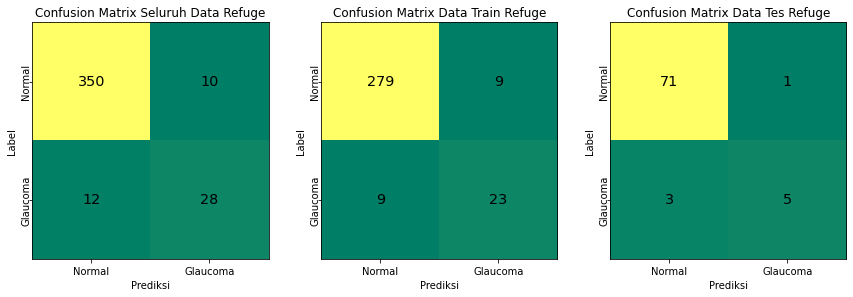

Seluruh data  | Train      | Test
Acc 1: 0.945  | Acc 2: 0.944 | Acc 3: 0.950
Sen 1: 0.700  | Sen 2: 0.719 | Sen 3: 0.625
Spe 1: 0.972  | Spe 2: 0.969 | Spe 3: 0.986
F1   : 0.718  | F2   : 0.719 | F3   : 0.714


In [ ]:
print('LR 2a')
y_pred = model2a.predict(x2a)
y_true = y
confusion_m(y_pred, y_true, re_tr, re_ts,'Refuge')

Thresholding


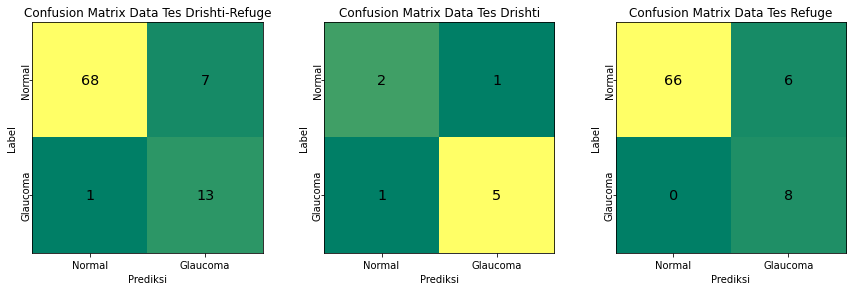

Seluruh data  | Drishti      | Refuge
Acc 1: 0.910  | Acc 2: 0.778 | Acc 3: 0.925
Sen 1: 0.929  | Sen 2: 0.833 | Sen 3: 1.000
Spe 1: 0.907  | Spe 2: 0.667 | Spe 3: 0.917
F1   : 0.765  | F2   : 0.833 | F3   : 0.727
LR 1


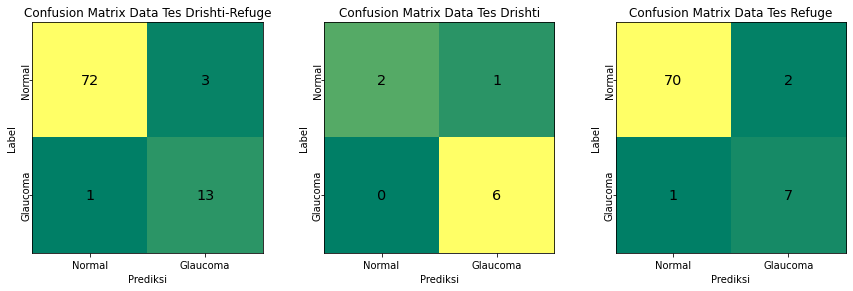

Seluruh data  | Drishti      | Refuge
Acc 1: 0.955  | Acc 2: 0.889 | Acc 3: 0.963
Sen 1: 0.929  | Sen 2: 1.000 | Sen 3: 0.875
Spe 1: 0.960  | Spe 2: 0.667 | Spe 3: 0.972
F1   : 0.867  | F2   : 0.923 | F3   : 0.824
LR 2a


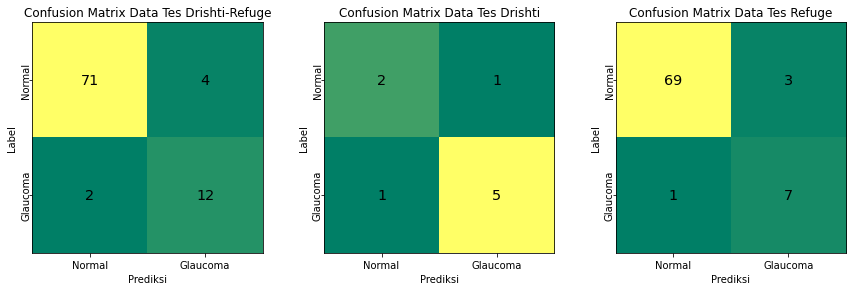

Seluruh data  | Drishti      | Refuge
Acc 1: 0.933  | Acc 2: 0.778 | Acc 3: 0.950
Sen 1: 0.857  | Sen 2: 0.833 | Sen 3: 0.875
Spe 1: 0.947  | Spe 2: 0.667 | Spe 3: 0.958
F1   : 0.800  | F2   : 0.833 | F3   : 0.778
LR 2b


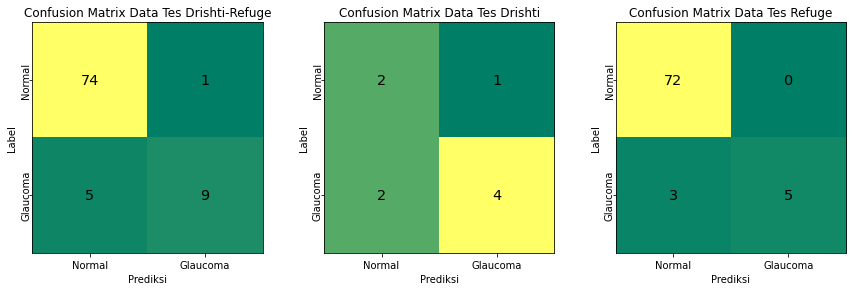

Seluruh data  | Drishti      | Refuge
Acc 1: 0.933  | Acc 2: 0.667 | Acc 3: 0.963
Sen 1: 0.643  | Sen 2: 0.667 | Sen 3: 0.625
Spe 1: 0.987  | Spe 2: 0.667 | Spe 3: 1.000
F1   : 0.750  | F2   : 0.727 | F3   : 0.769
LR 3


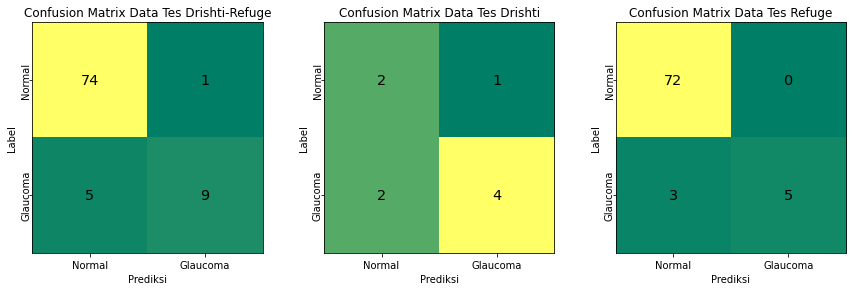

Seluruh data  | Drishti      | Refuge
Acc 1: 0.933  | Acc 2: 0.667 | Acc 3: 0.963
Sen 1: 0.643  | Sen 2: 0.667 | Sen 3: 0.625
Spe 1: 0.987  | Spe 2: 0.667 | Spe 3: 1.000
F1   : 0.750  | F2   : 0.727 | F3   : 0.769


In [ ]:
print('Thresholding')
y_pred = threshold_pred(x1a, threshold=0.54)
y_true = y
confusion_m(y_pred, y_true, partial=True, ix=test_ix)

print('LR 1')
y_pred = model1a.predict(x_GT1a)
confusion_m(y_pred, y_true, partial=True, ix=test_ix)

print('LR 2a')
y_pred = model2a.predict(x2a)
confusion_m(y_pred, y_true, partial=True, ix=test_ix)

print('LR 2b')
y_pred = model2b.predict(x2b)
confusion_m(y_pred, y_true, partial=True, ix=test_ix)

print('LR 3')
y_pred = model3.predict(x3)#_proba(x_GT3)[:, 1]
#y_pred = threshold_pred(y_pred, threshold=0.43)
confusion_m(y_pred, y_true, partial=True, ix=test_ix)